In [1]:
from eda import *
from models_utils import *
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pygam import LinearGAM, s
from gradientBoosting import *
from mertonJumpDiffusion import *
from scipy.special import inv_boxcox
from scipy import stats
import matplotlib.dates as mdates
from math import sqrt
import warnings
from cycler import cycler
from statsmodels.stats.diagnostic import acorr_ljungbox


warnings.filterwarnings('ignore')

plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

custom_colors = ["#948B80", "#625D56", "#312E2B", "#875C62", "#5F4045", "#B79DA1",
                "#417156", "#2E4F3C", "#6D7C73"]

# Table of contents
1. [Preprocessing](#preprocessing)
    1. [Train/Test split](#traintest)
    2. [Benchmark models](#benchmark)
    3. [Autocorrelation](#autocorr)
    4. [Stationarity](#stationarity)
    5. [Data transformation](#transformation)
2. [Models](#models)
    1. [ARIMA (AR, MA, ARMA, AND ARIMA)](#arima)
    2. [ARIMAX](#arimax)
    3. [Gradient Boosting](#boosting)
    4. [Merton Jump Diffusion Model](#diffusion)
3. [Results](#results)
4. [Investment Strategy](#investment)

# Preprocessing <a name="preprocessing"></a>


## Train /Test split<a name="traintest"></a>

Split the time seris into a train (85%) and test (15%) series

In [91]:
currency='BTC-USD'

train_df, test_df = load_train_val_test_data(
    file_name='data/exchange_v2.csv', 
    currency=currency,
    sizes=(0.85, 0.15)
)


# Add a new column to each dataframe to indicate the dataset type
train_df['Dataset'] = 'Train'
#val_df['Dataset'] = 'Validation'
test_df['Dataset'] = 'Test'

# Concatenate the dataframes
combined_df = pd.concat([train_df,test_df])

# Create a single chart with a color encoding based on the dataset type
chart = alt.Chart(combined_df).mark_line(strokeWidth=0.8).encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y=alt.Y('Close:Q', scale=alt.Scale(domain=[combined_df['Close'].min() - 0.05, combined_df['Close'].max() + 0.05])),
    color=alt.Color('Dataset:N', scale=alt.Scale(range=["#625D56", "#875C62", "#2E4F3C"]))
).properties(
    width=800,
    height=300,
    title=f"{currency} Exchange Rate: Train/Test Split"
)

chart.save('graphs/btcusd/a_train_validation_test_split.json')
chart

alt.Chart(...)

## Benchmark models<a name="benchmark"></a>

Naive models for used for model evaluation. For a model to be considered useful it has to at least perform better then the benchmarking models
- mean of the train series
- last value of the train series
- drift of the train series
- values of he last season (last 90 days) 


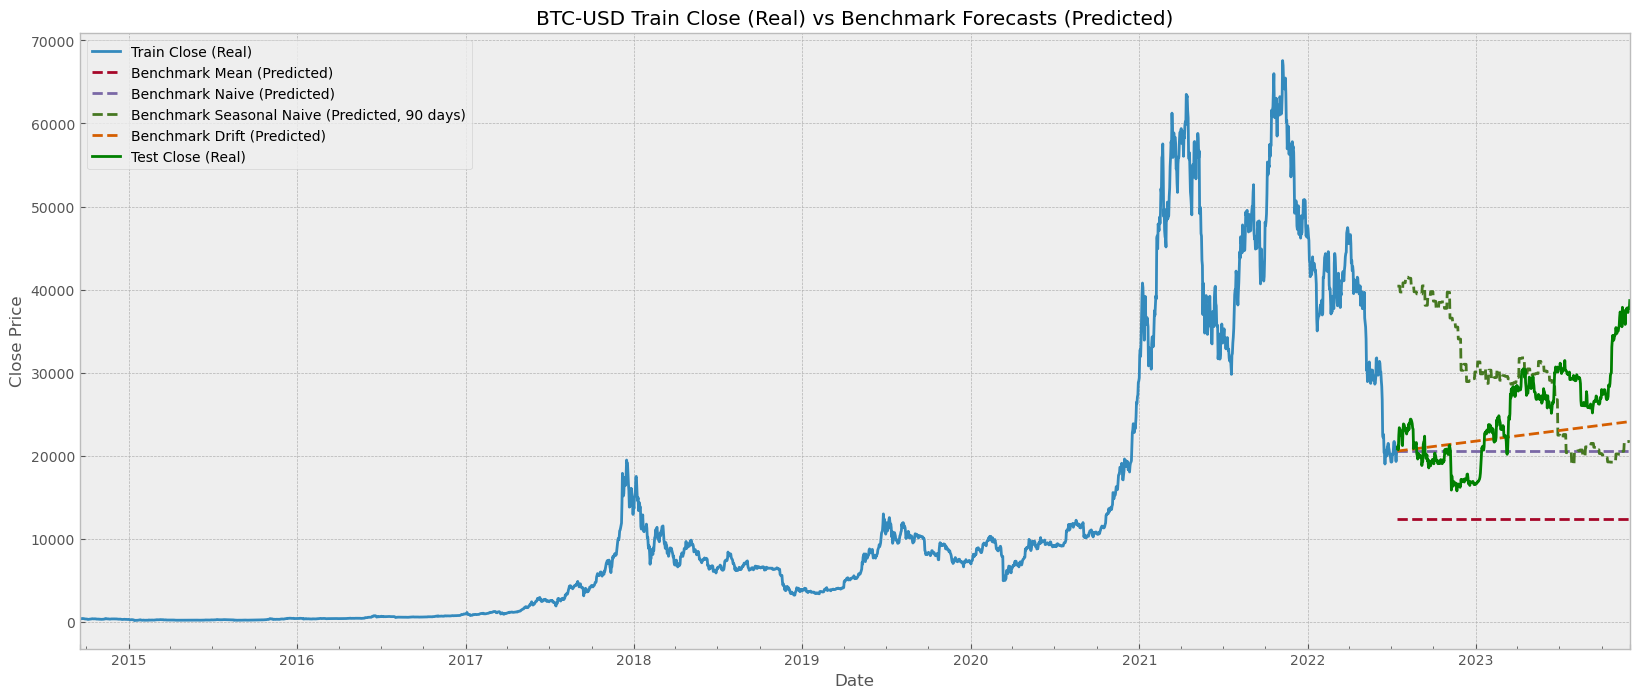

In [92]:
train_df, charts = preprocess(train_df, windows=(1, 3, 7, 30, 90, 365))
train_df, test_df = calc_benchmarks(train_df, test_df, seasonality=90)

In [93]:
benchmark_cols = [col for col in test_df.columns if "bench" in col]
benchmark_cols.append('Close')

# Reshape the DataFrame
long_df = test_df.melt(id_vars=['date'], value_vars=benchmark_cols, var_name='Benchmark', value_name='Value')

# Create the Altair Chart
chart = alt.Chart(long_df).mark_line(strokeWidth=0.6, point=False).encode(
    x=alt.X('date:T', axis=alt.Axis(format='%Y-%m')),
    y=alt.Y('Value:Q', scale=alt.Scale(domain=[10000, 50000])),
    color=alt.Color('Benchmark:N', scale=alt.Scale(range=custom_colors))
).properties(
    width=800,
    height=300,
    title=f"{currency} Benchmark models against Test Dataset."
).configure_point(
    size=10
)

# Line chart for actual data
actual_line = alt.Chart(long_df).mark_area(
    line={"color": "#F6E8D6", "strokeWidth":0.3},
    color=alt.Gradient(
        gradient="linear",
        stops=[
            alt.GradientStop(color="white", offset=0),
            alt.GradientStop(color="#F6E8D6", offset=1),
        ],
        x1=1,
        x2=1,
        y1=1,
        y2=0,
    ),
    strokeDash=[1,1]
).encode(
    y=alt.Y('Close:Q', scale=alt.Scale(domain=[10000, 50000]))
)

# Save the chart
chart.save('graphs/btcusd/b_benchmarks.json')

chart

alt.Chart(...)

Text(0.5, 1.0, 'Benchmark Residuals Plot')

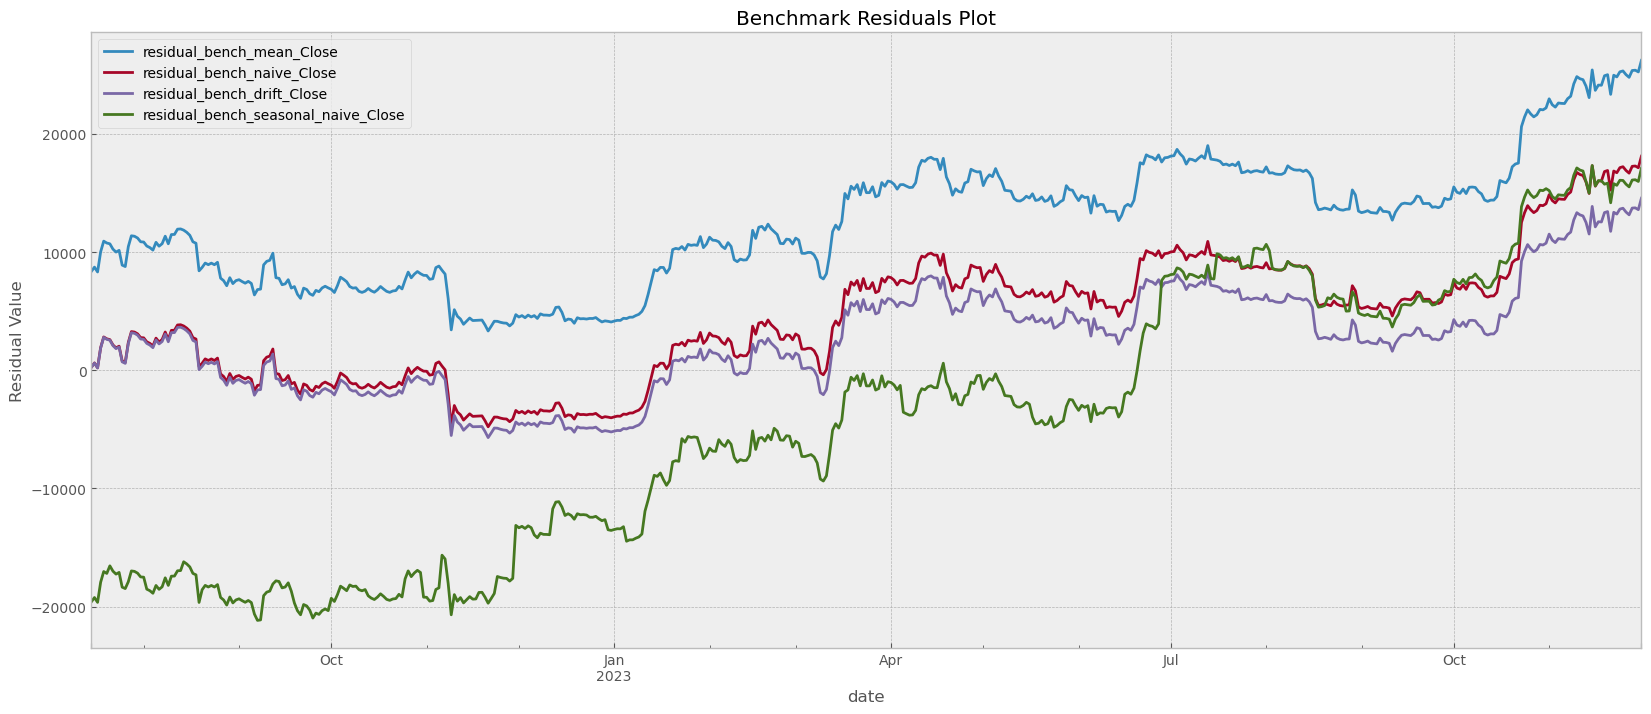

In [94]:
# List of benchmark columns
benchmark_cols = ['bench_mean_Close', 'bench_naive_Close', 
                  'bench_drift_Close', 'bench_seasonal_naive_Close']

# Calculate residuals and store in a new DataFrame
residuals_df = pd.DataFrame()

for col in benchmark_cols:
    residuals_df[f'residual_{col}'] = test_df['Close'] - test_df[col]
    
residuals_df.plot()

plt.ylabel("Residual Value")
plt.title("Benchmark Residuals Plot")

In [95]:
#calculate metrics for the benchmarking models
benchmark_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=benchmark_cols)
#benchmark_metrics.to_csv("graphs/btcusd/benchmark_metrics.csv")
benchmark_metrics.T

MAE           MSE          RMSE   
bench_mean_Close            12462.971646  1.841994e+08  13572.008284  \
bench_naive_Close            5562.778895  4.783143e+07   6916.026724   
bench_drift_Close            4259.440336  2.769475e+07   5262.579713   
bench_seasonal_naive_Close  10510.395003  1.502285e+08  12256.774267   

                                 MAPE        R2  
bench_mean_Close            47.570239 -5.379477  
bench_naive_Close           20.449146 -0.656571  
bench_drift_Close           16.324904  0.040833  
bench_seasonal_naive_Close  47.236010 -4.202945

# Other charts of interest 

In [96]:
for chart in charts:
    chart.display()

alt.Chart(...)

alt.LayerChart(...)

In [97]:
# Plot of first difference to show that it is stationary 

## Autocorrelation<a name="autocorr"></a>

Check the autocorrelation to identify possible seasonal patterns and signficant lags in the time series

 #### Autocorrelation of the Close price of the train data series

[]

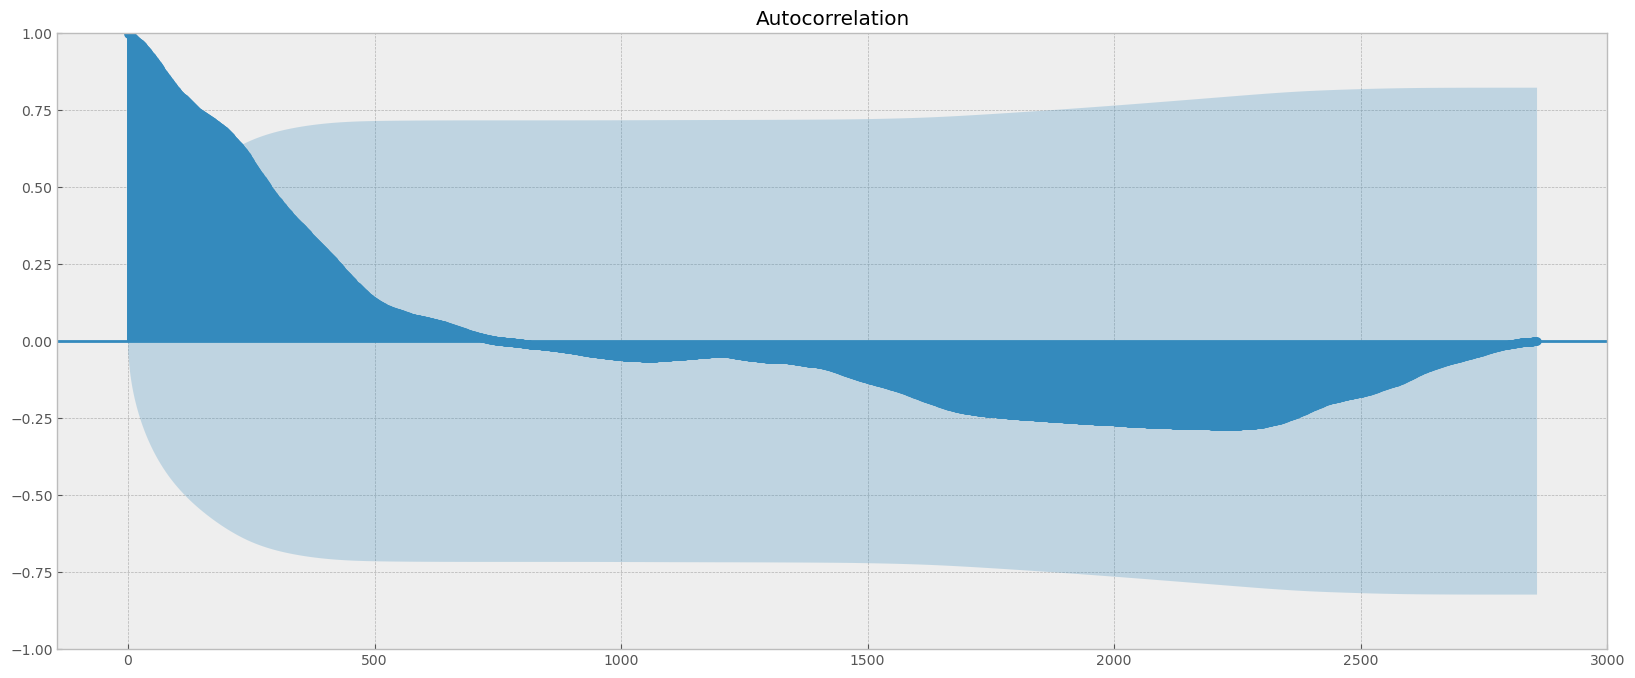

In [98]:
plot_acf((train_df['Close']).dropna(), lags=len(train_df)-1)
plt.plot()

No significant seasonal lags observed so it can be assumd that there is no clear seasonality in the series

 #### Partial Autocorrelation of the Close price of the train data series

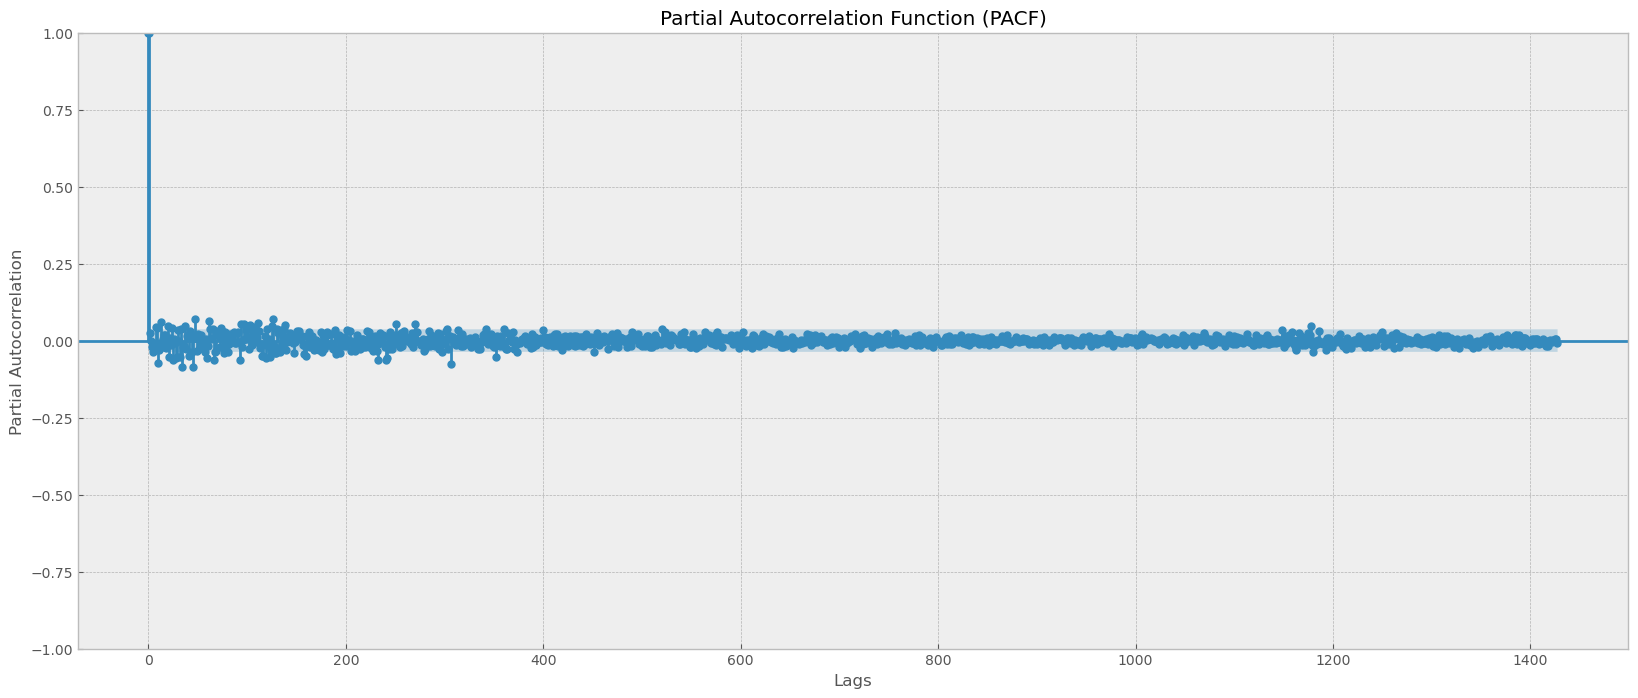

In [99]:
plot_pacf(train_df['Close'], lags=(len(train_df)/2)-2)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

No significant spike other than lag 0 which confirms the assumptions that the timeseries has no seasonality

## Stationarity<a name="stationarity"></a>

The time series is not stationary therefore we check how the first order difference behaves

In [100]:
#plot first order difference

#### Autocorrelation on 1st order differenciation (1 day)


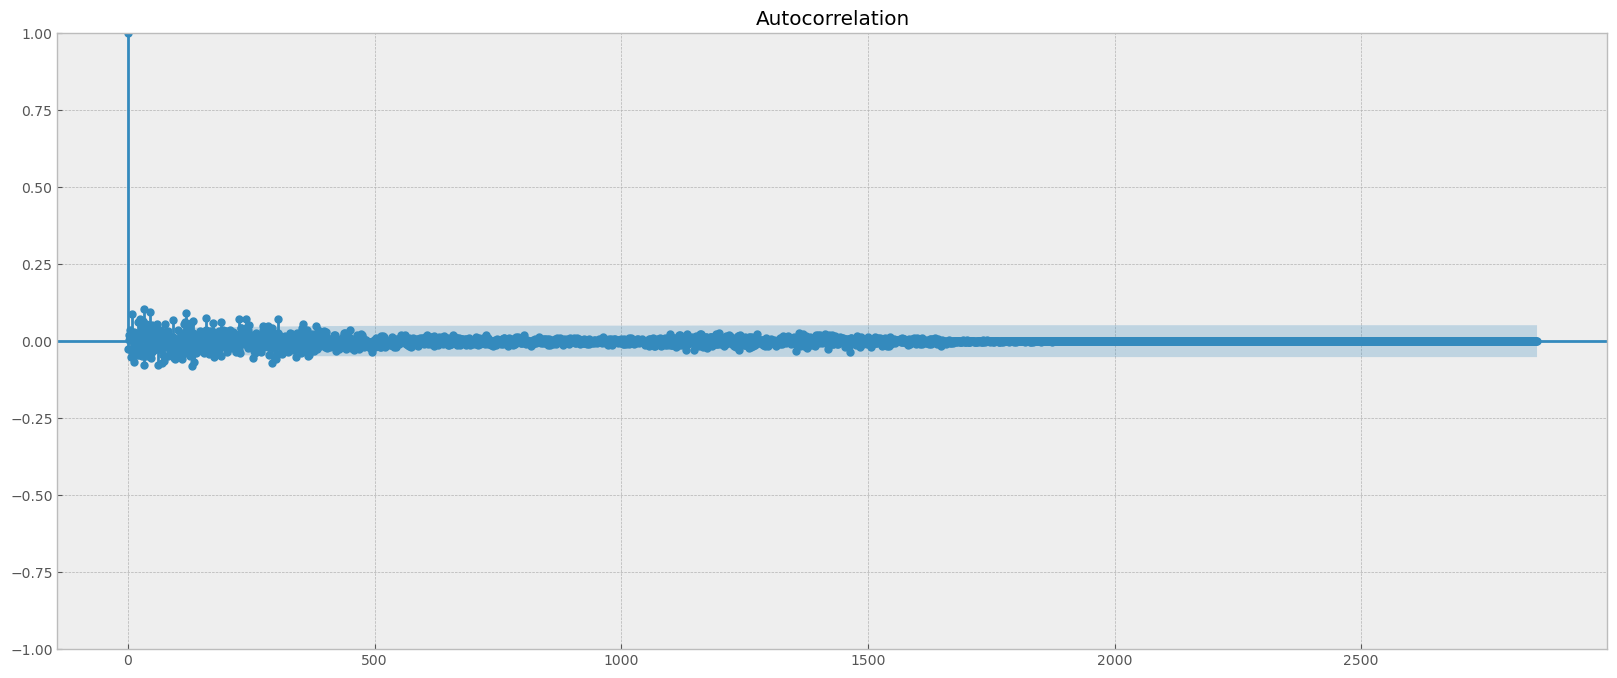

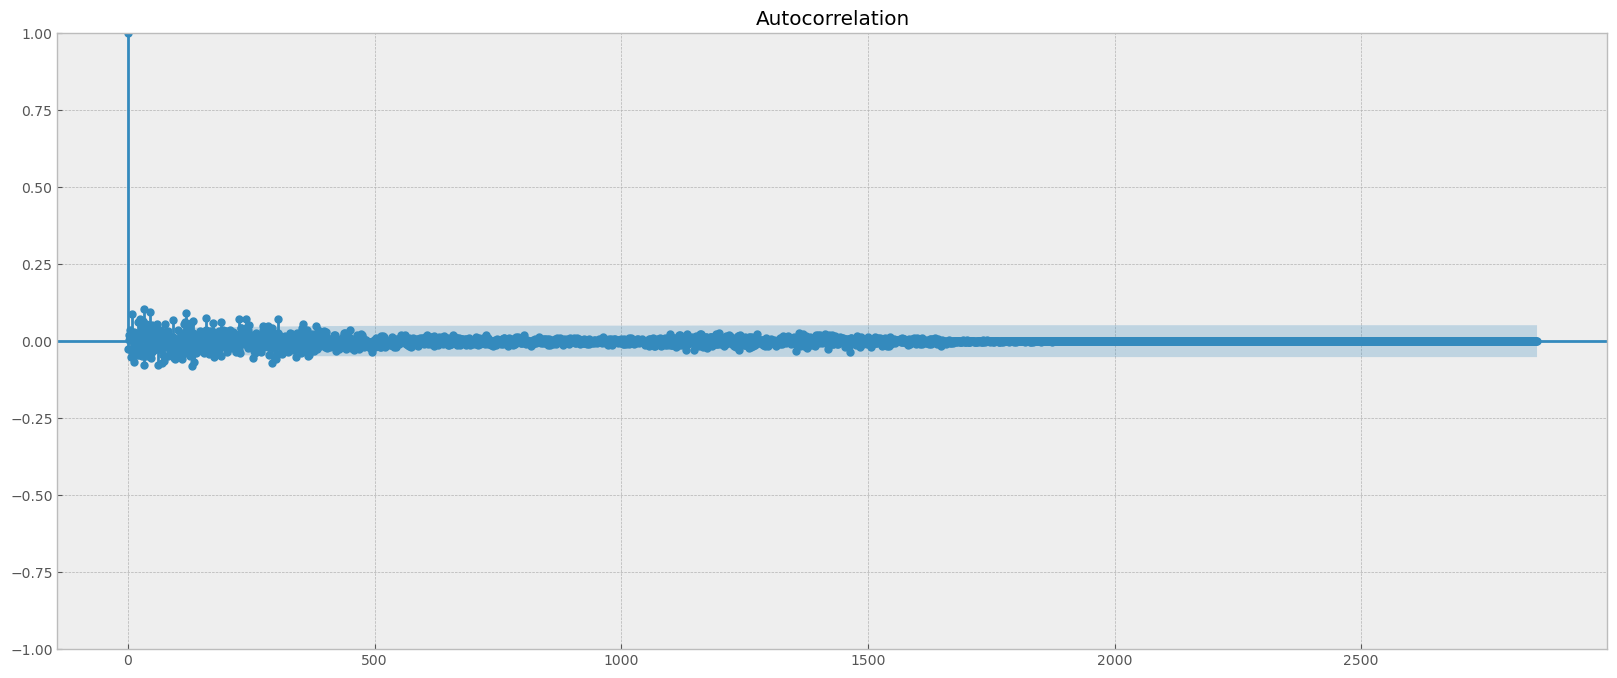

In [101]:
plot_acf((train_df['Close']-train_df['Close'].shift(1)).dropna(), lags=len(train_df)-2)

Autocorrelation indicates that first difference is (almost) stationary 

## Data transformation<a name="#transformation"></a>

The value of Bitcoin exhibits significant volatility, which can confuse or worsen the performance of some models. To mitigate this, we perform a Box Cox transform to stabilize it.

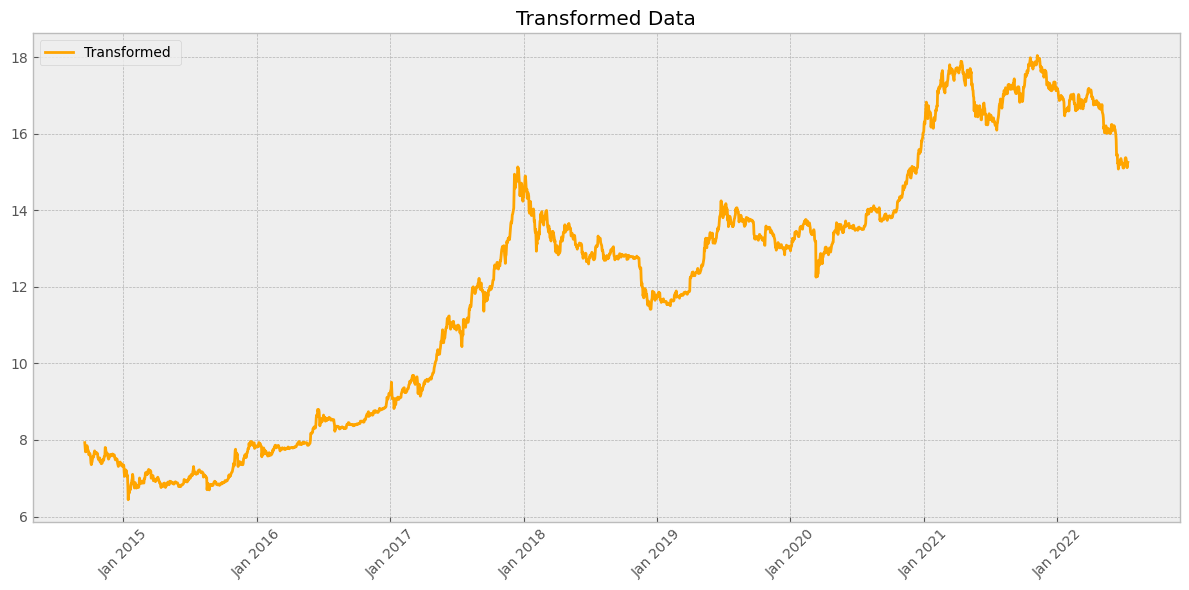

In [102]:
# # Apply box-cox transformation to the data
train_df['transf'], lambda_optimal = stats.boxcox(train_df['Close'])

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(train_df['date']), train_df['transf'], label='Transformed ', color='orange')
plt.title('Transformed Data')
plt.legend()
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [103]:
#return the inverse of the transformation
def inverse_bocxcx(predictions, lambda_optimal):
    predictions = inv_boxcox(predictions, lambda_optimal)
    
    return predictions

# Models<a name="models"></a>

## ARIMA (AR, MA, ARMA, AND ARIMA)<a name="arima"></a>

Fit arima model based on the box cox transformation of the train dataset 

In [104]:
def create_arima_model(df, ar_order=1, i_order=0, ma_order=1, feature='transf', transformed = False):
    df_copy = df.copy()
    model_fit = ARIMA(df_copy[feature], order=(ar_order, i_order, ma_order)).fit()
    start_point = max((ar_order, ma_order, i_order))
    predictions = model_fit.predict(start=start_point, end=len(df_copy)-1, dynamic=False)
    
    #reverse transformation for the predictions
    if transformed:
        predictions = inv_boxcox(predictions, lambda_optimal)
    
    # Reset indices to align the data
    df_copy = df_copy.reset_index(drop=True)
    predictions_reset = predictions.reset_index(drop=True)
    
    # Restore the original index
    df_copy.index = df.index
    predictions_reset.index = predictions.index
    
    df_copy[f'arima{ar_order}_{i_order}_{ma_order}_prediction'] = predictions
    
    return df_copy, model_fit, predictions_reset

In [105]:
def arima_forecast(df,model_fit):
    df_copy = df.copy()
    predictions = model_fit.forecast(steps=len(df_copy))
    predictions = inv_boxcox(predictions, lambda_optimal)
    
    df_copy[f'arima{ar_order}_{i_order}_{ma_order}_prediction'] = predictions
    
    return df_copy, predictions

In [106]:
#select best model based on AIC
def select_best_model(models):
    
    aic = models[0].aic
    model_fit = models[0]
    order = models[0].model.order
    
    for model in models:
        if model.aic < aic:
            aic = model.aic
            model_fit = model 
            order = model.model.order

    return model_fit


Performance on the train data

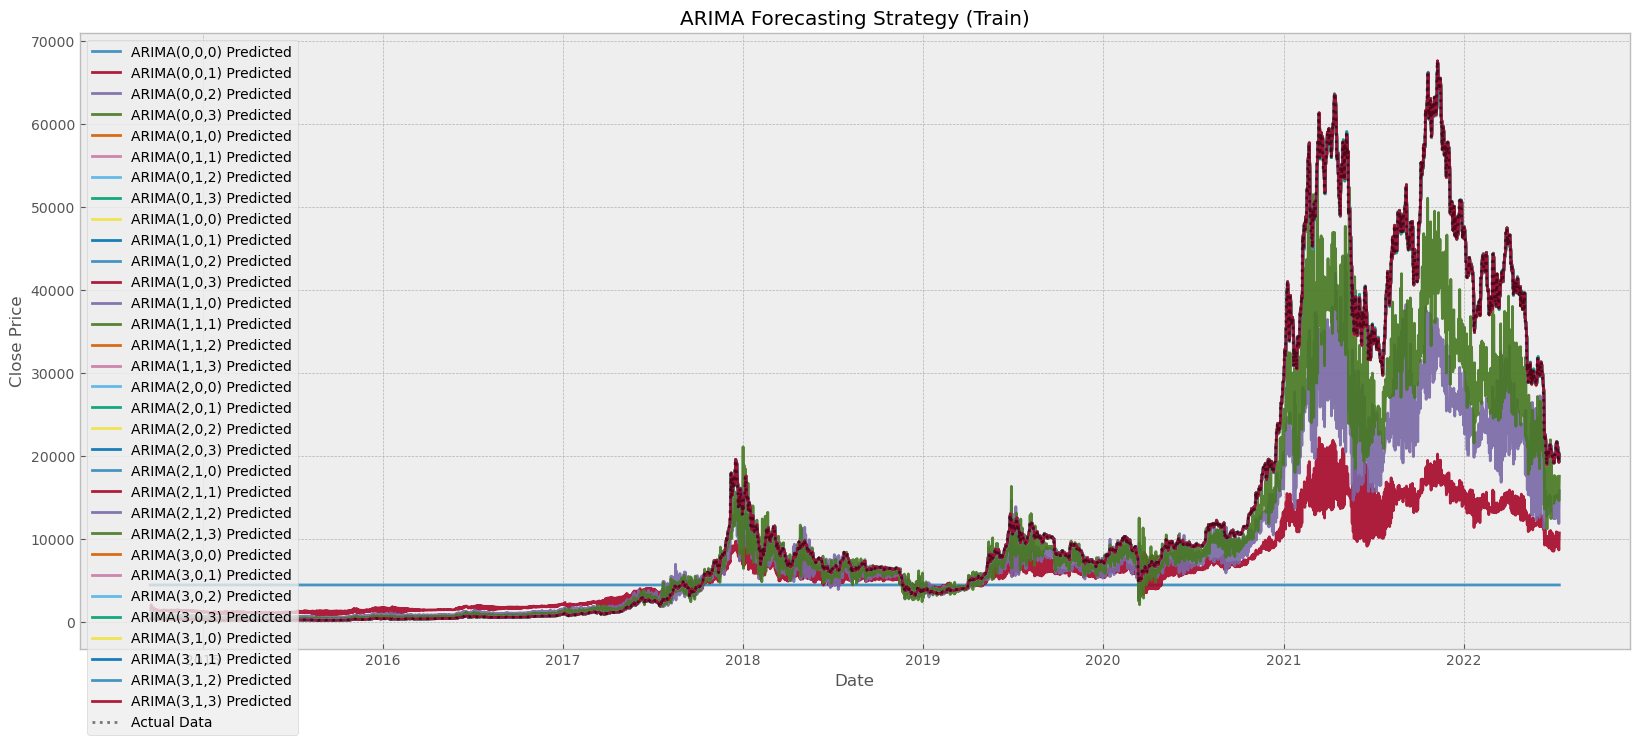

In [107]:
models = []
# Different combinations of AR and MA orders
arima_combinations = [(ar, i, ma) for ar in range(0,4) for i in [0,1] for ma in range(0,4)] 


for ar_order, i_order, ma_order in arima_combinations:
    train_df, model_arima, predictions_arima = create_arima_model(train_df, ar_order=ar_order, i_order=i_order, ma_order=ma_order, feature='transf', transformed = True)

    # Calculate the starting index for plotting
    start_index_for_plot = max((ar_order, ma_order, i_order))

    #plot model
    plt.plot(train_df.index[start_index_for_plot:], predictions_arima, label=f'ARIMA({ar_order},{i_order},{ma_order}) Predicted', alpha=0.9)
    models.append(model_arima)

plt.plot(train_df['Close'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
plt.title(f'ARIMA Forecasting Strategy (Train)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [108]:
train_df.head()

date        Open        High         Low       Close   
date                                                                    
2014-09-17 2014-09-17  465.864014  468.174011  452.421997  457.334015  \
2014-09-18 2014-09-18  456.859985  456.859985  413.104004  424.440002   
2014-09-19 2014-09-19  424.102997  427.834991  384.532013  394.795990   
2014-09-20 2014-09-20  394.673004  423.295990  389.882996  408.903992   
2014-09-21 2014-09-21  408.084991  412.425995  393.181000  398.821014   

             Adj Close    Volume currency Dataset        mov1  ...   
date                                                           ...   
2014-09-17  457.334015  21056800  BTC-USD   Train  457.334015  ...  \
2014-09-18  424.440002  34483200  BTC-USD   Train  424.440002  ...   
2014-09-19  394.795990  37919700  BTC-USD   Train  394.795990  ...   
2014-09-20  408.903992  36863600  BTC-USD   Train  408.903992  ...   
2014-09-21  398.821014  26580100  BTC-USD   Train  398.821014  ...   

            arima2_1_2_prediction  arima2_1_3_prediction   
date                                                       
2014-09-17                    NaN                    NaN  \
2014-09-18                    NaN                    NaN   
2014-09-19             424.934343                    NaN   
2014-09-20             394.541847             394.827574   
2014-09-21             407.915881             407.944910   

            arima3_0_0_prediction  arima3_0_1_prediction   
date                                                       
2014-09-17                    NaN                    NaN  \
2014-09-18                    NaN                    NaN   
2014-09-19                    NaN                    NaN   
2014-09-20             395.293277             395.393574   
2014-09-21             408.536575             408.794139   

            arima3_0_2_prediction  arima3_0_3_prediction   
date                                                       
2014-09-17                    NaN                    NaN  \
2014-09-18                    NaN                    NaN   
2014-09-19                    NaN                    NaN   
2014-09-20             394.615293             395.413379   
2014-09-21             409.080739             408.941414   

            arima3_1_0_prediction  arima3_1_1_prediction   
date                                                       
2014-09-17                    NaN                    NaN  \
2014-09-18                    NaN                    NaN   
2014-09-19                    NaN                    NaN   
2014-09-20             394.852904             394.852697   
2014-09-21             407.651390             407.651213   

            arima3_1_2_prediction  arima3_1_3_prediction  
date                                                      
2014-09-17                    NaN                    NaN  
2014-09-18                    NaN                    NaN  
2014-09-19                    NaN                    NaN  
2014-09-20             394.810034             394.384797  
2014-09-21             407.938075             408.067183  

[5 rows x 51 columns]

Best model based on AIC

In [109]:
best_model = select_best_model(models)
best_model.model.order

(1, 1, 2)

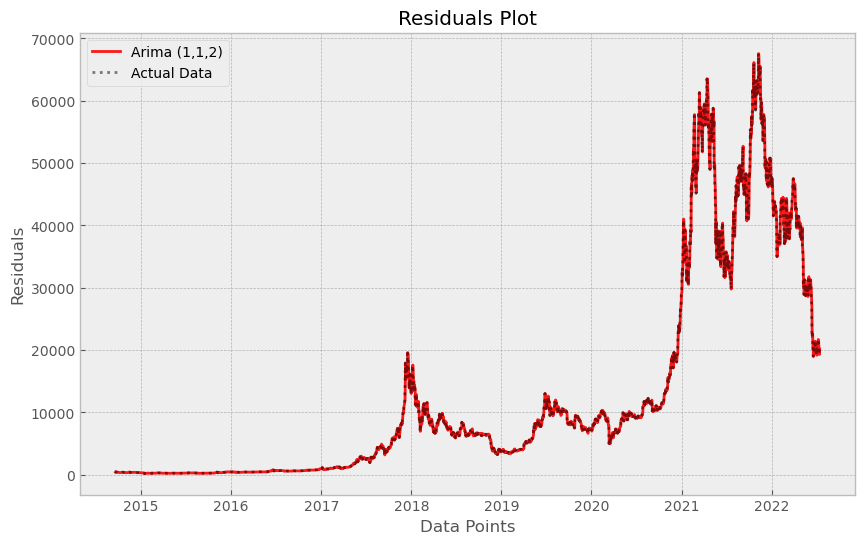

In [110]:
plt.figure(figsize=(10, 6))
plt.plot(train_df['arima1_1_2_prediction'], label='Arima (1,1,2)', color='red', alpha=0.9)
plt.plot(train_df['Close'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
plt.title('Residuals Plot')
plt.xlabel('Data Points')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

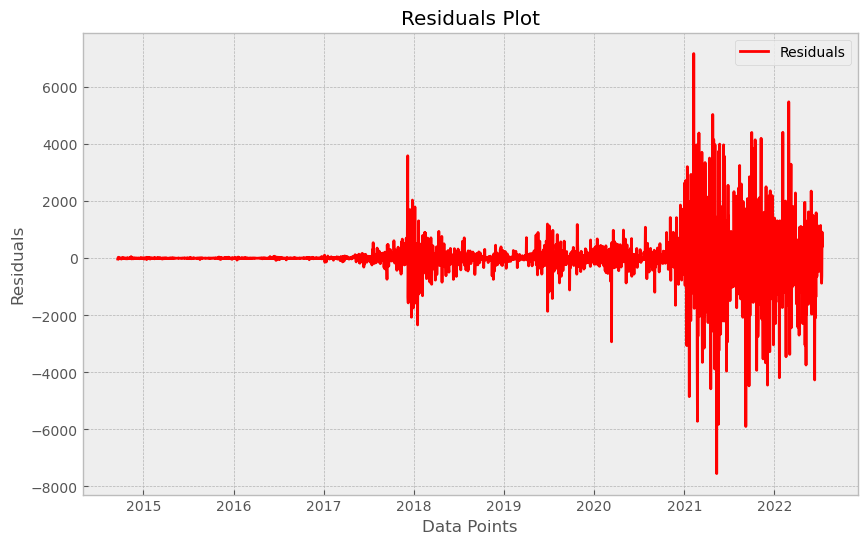

In [111]:
train_df['arima1_1_2_residuals'] = train_df['Close'] - train_df['arima1_1_2_prediction']

plt.figure(figsize=(10, 6))
plt.plot(train_df['arima1_1_2_residuals'], label='Residuals', color='red')
plt.title('Residuals Plot')
plt.xlabel('Data Points')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
mean_residuals = train_df['arima1_1_2_residuals'].mean()
print(f"Mean of residuals: {mean_residuals}")

Mean of residuals: 0.8096817897815923


In [113]:
sm.stats.acorr_ljungbox(train_df['arima1_1_2_residuals'].dropna(), lags=[7,30,90,365,730], return_df=True)

lb_stat     lb_pvalue
7      14.029898  5.065213e-02
30    126.244032  9.017646e-14
90    405.056666  1.619829e-41
365  1139.107263  1.783493e-80
730  1322.709246  8.383107e-37

ARIMA(1,1,2) is a significant model that describes training data well as the residuals are (almost) a white noise Process and for common seasonal lags the Ljung Box test works

### Performance on the test data

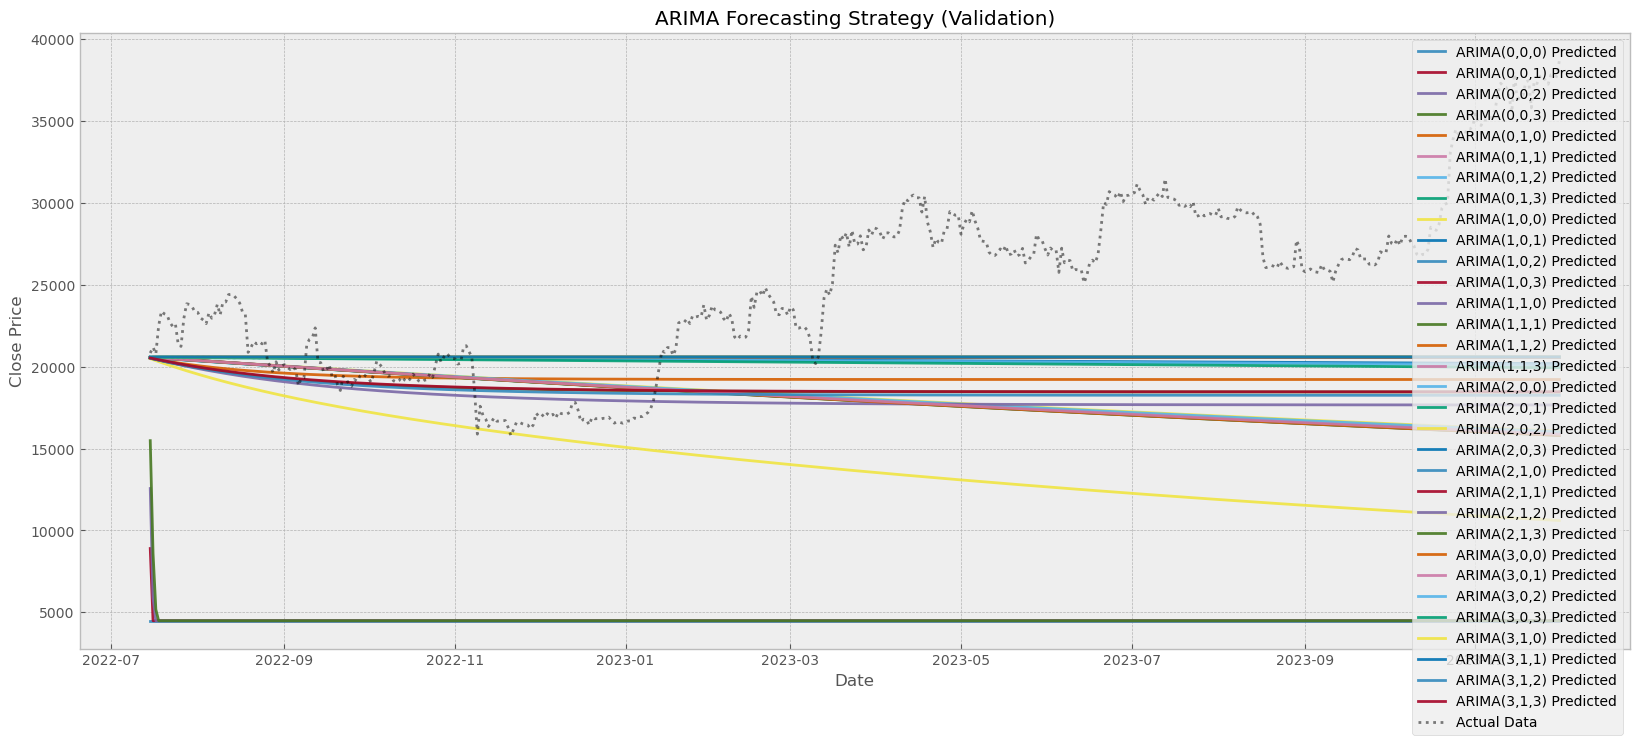

In [114]:
#get and plot predictions for the test dataset
for (ar_order, i_order, ma_order), model in zip(arima_combinations, models):
    test_df,predictions_arima = arima_forecast(test_df,model_fit=model)
    
    plt.plot(test_df.index, predictions_arima, label=f'ARIMA({ar_order},{i_order},{ma_order}) Predicted', alpha=0.9)

plt.plot(test_df['Close'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
plt.title(f'ARIMA Forecasting Strategy (Validation)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Best model ARIMA (1,1,2)

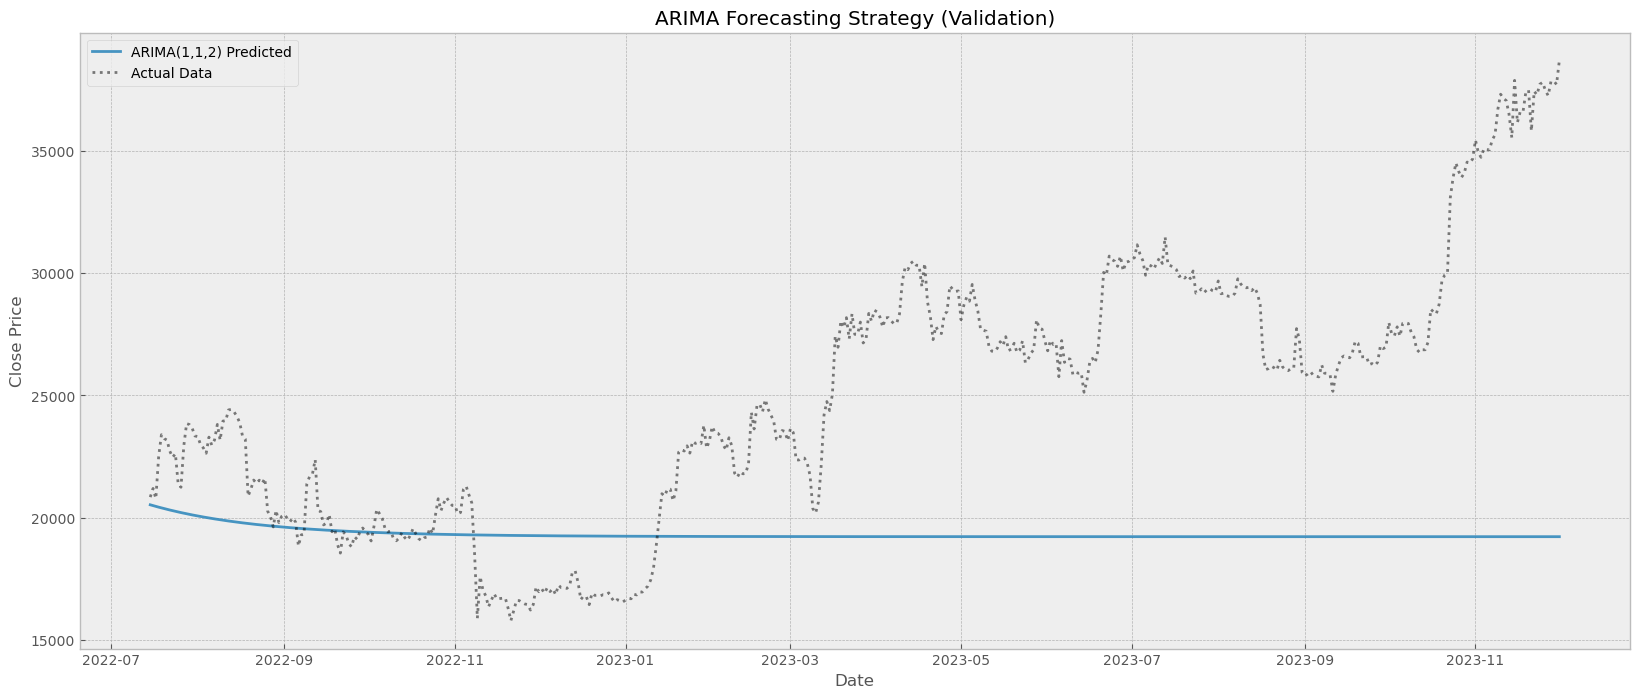

In [115]:
plt.plot(test_df.index, test_df['arima1_1_2_prediction'], label=f'ARIMA(1,1,2) Predicted', alpha=0.9)
plt.plot(test_df['Close'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
plt.title(f'ARIMA Forecasting Strategy (Validation)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [116]:
#get metrics of the quality of the forecast
arima_cols = [f'arima{ar}_{i}_{ma}_prediction' for ar,i, ma in arima_combinations]
arima_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=arima_cols)
arima_metrics.T.sort_values(by='MSE', ascending=True)

MAE           MSE          RMSE       MAPE   
arima3_1_0_prediction   5551.118261  4.761991e+07   6900.717792  20.416673  \
arima3_1_1_prediction   5551.135243  4.762020e+07   6900.739054  20.416722   
arima1_1_3_prediction   5552.006300  4.763591e+07   6901.877103  20.419154   
arima0_1_3_prediction   5552.128618  4.763819e+07   6902.042687  20.419486   
arima0_1_2_prediction   5555.576444  4.770107e+07   6906.596149  20.429039   
arima2_1_0_prediction   5555.834507  4.770574e+07   6906.934289  20.429758   
arima2_1_1_prediction   5558.658884  4.775253e+07   6910.320290  20.438141   
arima0_1_0_prediction   5562.778895  4.783143e+07   6916.026724  20.449146   
arima1_1_1_prediction   5564.490768  4.786240e+07   6918.265572  20.453934   
arima1_1_0_prediction   5566.181707  4.789305e+07   6920.480595  20.458659   
arima0_1_1_prediction   5566.296820  4.789514e+07   6920.631702  20.458980   
arima2_0_3_prediction   5706.566770  5.046171e+07   7103.640864  20.916991   
arima3_0_2_prediction   5734.649603  5.098640e+07   7140.476468  21.007942   
arima3_0_3_prediction   5806.214910  5.232786e+07   7233.799987  21.235478   
arima1_1_2_prediction   6247.337040  6.099576e+07   7809.978170  22.484260   
arima3_1_3_prediction   6686.893308  6.950918e+07   8337.216857  23.950680   
arima2_1_3_prediction   6698.928145  6.966355e+07   8346.469509  23.996005   
arima3_1_2_prediction   6821.893599  7.211608e+07   8492.118618  24.415253   
arima2_1_2_prediction   7167.186111  7.937735e+07   8909.396830  25.595323   
arima1_0_0_prediction   7400.316717  8.730744e+07   9343.844789  26.429942   
arima2_0_0_prediction   7422.397207  8.785621e+07   9373.164325  26.501579   
arima3_0_1_prediction   7483.086861  8.939019e+07   9454.638664  26.701839   
arima1_0_1_prediction   7486.324561  8.946254e+07   9458.464171  26.711287   
arima1_0_2_prediction   7500.888929  8.984577e+07   9478.700756  26.761044   
arima1_0_3_prediction   7507.247109  9.001069e+07   9487.396310  26.782653   
arima3_0_0_prediction   7515.524238  9.021611e+07   9498.215951  26.808924   
arima2_0_1_prediction   7516.103734  9.022535e+07   9498.702588  26.810101   
arima2_0_2_prediction  10767.892049  1.719593e+08  13113.326549  38.773335   
arima0_0_3_prediction  20407.404091  4.458591e+08  21115.376733  80.978646   
arima0_0_2_prediction  20419.391183  4.461092e+08  21121.296763  81.036094   
arima0_0_1_prediction  20428.675131  4.463143e+08  21126.151500  81.080864   
arima0_0_0_prediction  20436.867976  4.465393e+08  21131.476979  81.120501   

                              R2  
arima3_1_0_prediction  -0.649246  
arima3_1_1_prediction  -0.649256  
arima1_1_3_prediction  -0.649800  
arima0_1_3_prediction  -0.649879  
arima0_1_2_prediction  -0.652057  
arima2_1_0_prediction  -0.652219  
arima2_1_1_prediction  -0.653839  
arima0_1_0_prediction  -0.656571  
arima1_1_1_prediction  -0.657644  
arima1_1_0_prediction  -0.658706  
arima0_1_1_prediction  -0.658778  
arima2_0_3_prediction  -0.747668  
arima3_0_2_prediction  -0.765840  
arima3_0_3_prediction  -0.812299  
arima1_1_2_prediction  -1.112499  
arima3_1_3_prediction  -1.407349  
arima2_1_3_prediction  -1.412695  
arima3_1_2_prediction  -1.497635  
arima2_1_2_prediction  -1.749119  
arima1_0_0_prediction  -2.023765  
arima2_0_0_prediction  -2.042771  
arima3_0_1_prediction  -2.095899  
arima1_0_1_prediction  -2.098404  
arima1_0_2_prediction  -2.111677  
arima1_0_3_prediction  -2.117389  
arima3_0_0_prediction  -2.124503  
arima2_0_1_prediction  -2.124823  
arima2_0_2_prediction  -4.955560  
arima0_0_3_prediction -14.441679  
arima0_0_2_prediction -14.450339  
arima0_0_1_prediction -14.457442  
arima0_0_0_prediction -14.465236

ARIMA models perform well on the train dataset but they have problems capturing the voitality in the test data. The ARIMA(1,1,2) model that performs best on the train data is not the one that performs the best on the test data. 

## ARIMAX<a name="arimax"></a>
add the timestamp(epoch) as an exogenious variable to the ARIMA model to try to better capture th viotality 

In [117]:
# Fit ARIMAX model
def train_and_plot_arima(df, orders, exg=None):
    models = []
    
    # Loop through each combination and plot the fitted values
    for ar_order, i_order, ma_order in arima_combinations:

        if exg is not None:
            model_fit = sm.tsa.SARIMAX(df, 
                                       exog=exg, 
                                       order=(ar_order, i_order, ma_order), 
                                       seasonal_order=(0, 0, 0, 0)).fit()
        else:    
            model_fit = ARIMA(df, order=(ar_order, i_order, ma_order)).fit()
            
        plt.plot(model_fit.fittedvalues, label=f'ARIMA({ar_order},{i_order},{ma_order})', alpha=0.5)
    
        # Save the model if you need it later
        models.append((model_fit, (ar_order, i_order, ma_order)))
        
    
    plt.plot(df, label="Original Dataset", color='black', alpha=0.9, linewidth=2)
    
    # Add legend and grid to the plot
    plt.legend()
    plt.grid(True)
    
    # Set the title and labels
    plt.title('Fitted Values of ARIMA Models')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    
    # Set the range of the y-axis here
    plt.ylim(0, 20)
    
    # Finally, show the plot
    plt.show()

    return models

#select best model based on AIC
def select_model(models):
    aic = models[0][0].aic
    model_fit = models[0][0]
    order = models[0][1]
    for model in models:
        if model[0].aic < aic:
            aic = model[0].aic
            model_fit = model[0]
            order = model[1]
            
    return model_fit

In [118]:
def forecast_and_plot(model_fit, df, test_df, transformed=False, lambda_optimal=None, exg=None):
    if exg is None:
        predictions = model_fit.forecast(steps=len(test_df['Close']))
    else:
        predictions = model_fit.forecast(steps=len(test_df['Close']), exog=exg)
    if transformed:
        predictions = inv_boxcox(predictions, lambda_optimal)
    
    # The index of 'predictions' should align with the index of 'test_df'
    predictions.index = test_df.index
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test_df["Close"], predictions))
    print('Test RMSE: %.3f' % rmse)
    
    # Plotting the results
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(df["Close"], label='Training Data')
    
    # Plot predicted values
    plt.plot(predictions, color='blue', label='Predicted Test Data')
    
    # Plot actual test values
    plt.plot(test_df["Close"], color='green', label='Actual Test Data')
    
    plt.title('Train, Predicted Test, and Actual Test Data')
    plt.legend()
    
    plt.show()
    
    return predictions

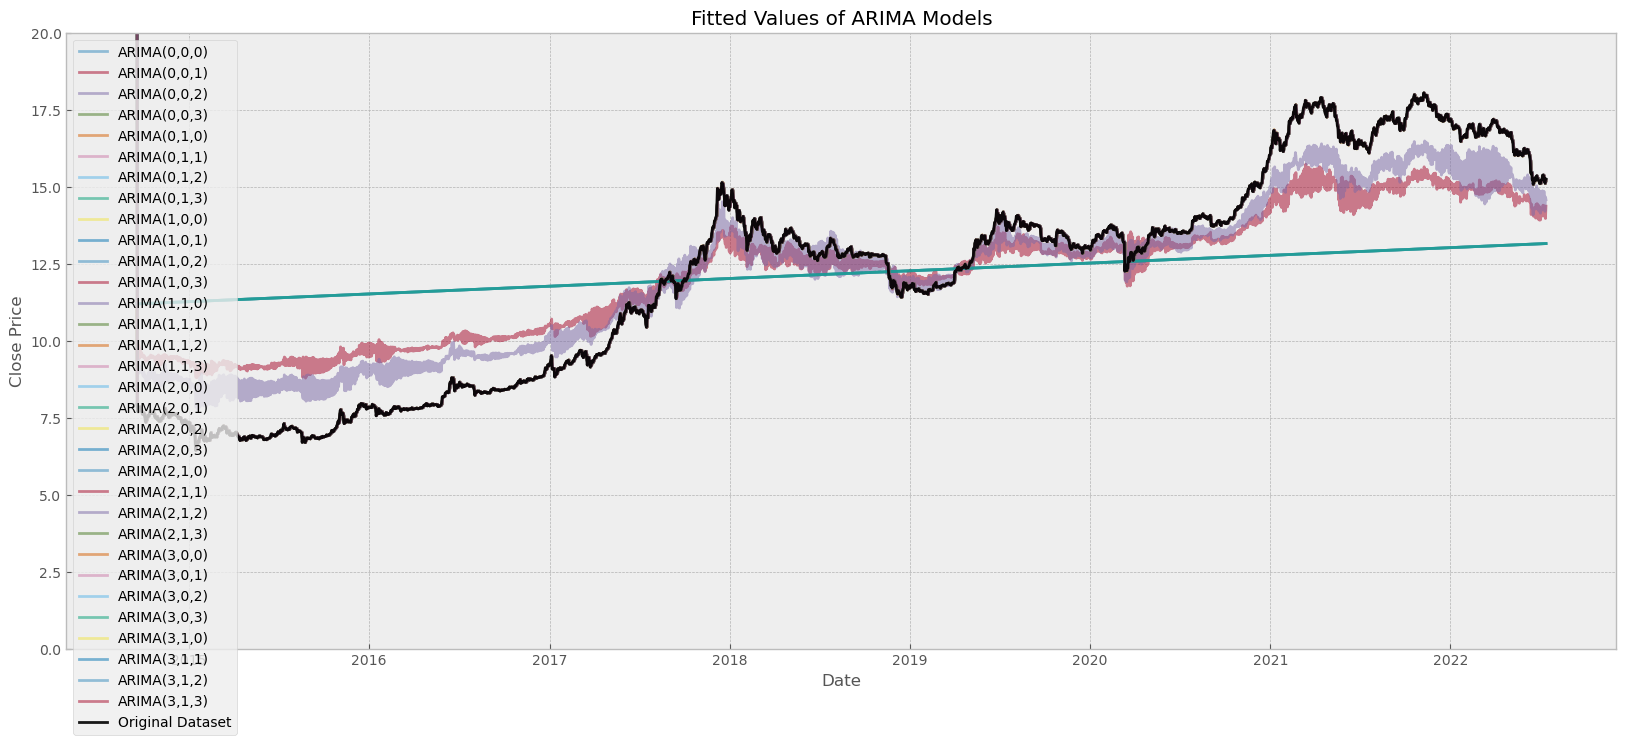

In [119]:
# Train ARIMAX
arima_combinations = [(ar, i, ma) for ar in range(0,4) for i in [0,1] for ma in range(0,4)]  # Different combinations of AR and MA orders
train_df['epoch'] = (train_df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
models = train_and_plot_arima(train_df['transf'], arima_combinations, exg=train_df['epoch'])

Best ARIMAX model is the model with order (1,1,0)

In [120]:
model_fit = select_model(models)

In [121]:
model_fit.model.order

(1, 1, 0)

Performace on the boxcox transformed train data

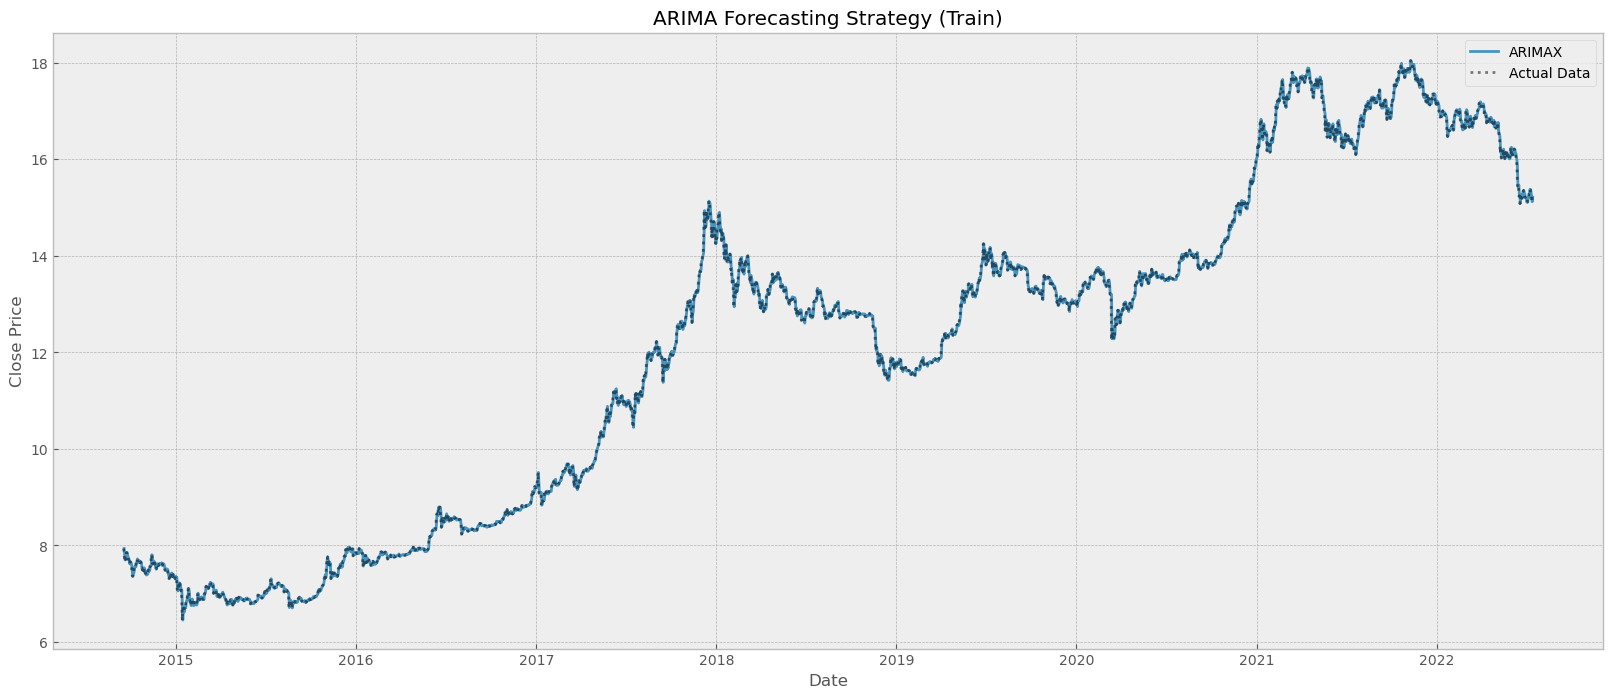

In [122]:
start_point = max(model_fit.model.order)
predictions = model_fit.predict(start=start_point, end=len(train_df)-1, dynamic=False)

train_df['ARIMAX_prediction'] = predictions

plt.plot(train_df.index[start_point:], predictions, label='ARIMAX', alpha=0.9)
plt.plot(train_df['transf'], label='Actual Data', color='black', alpha=0.5, linestyle='dotted')
plt.title(f'ARIMA Forecasting Strategy (Train)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Residuals

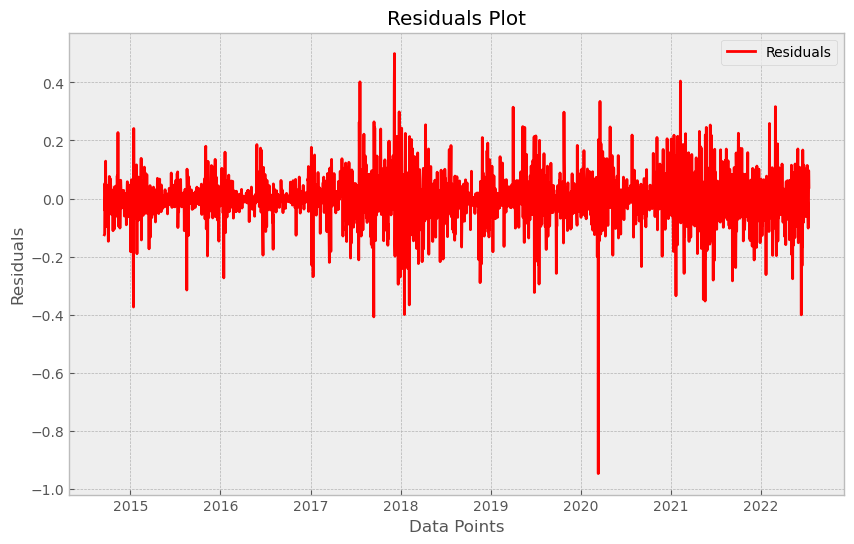

In [123]:
# Plot residuals
#train_df['arimax_residuals'] = train_df['Close'] - inv_boxcox(train_df['ARIMAX_prediction'],lambda_optimal)
train_df['arimax_residuals'] = train_df['transf'] - train_df['ARIMAX_prediction']


plt.figure(figsize=(10, 6))
plt.plot(train_df['arimax_residuals'], label='Residuals', color='red')
plt.title('Residuals Plot')
plt.xlabel('Data Points')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [124]:
mean_residuals = train_df['arimax_residuals'].mean()
variance_residuals = train_df['arimax_residuals'].var()

print(f"Mean of residuals: {mean_residuals}")
print(f"Variance of residuals: {variance_residuals}")

Mean of residuals: -2.7016569311618495e-07
Variance of residuals: 0.00634138164484275


In [125]:
sm.stats.acorr_ljungbox(train_df['arimax_residuals'].dropna(), lags=[1,30,90,365,730], return_df=True)

lb_stat  lb_pvalue
1      0.000325   0.985622
30    39.663763   0.111543
90   117.460213   0.027567
365  392.139167   0.157418
730  723.086319   0.565155

<Figure size 1000x600 with 0 Axes>

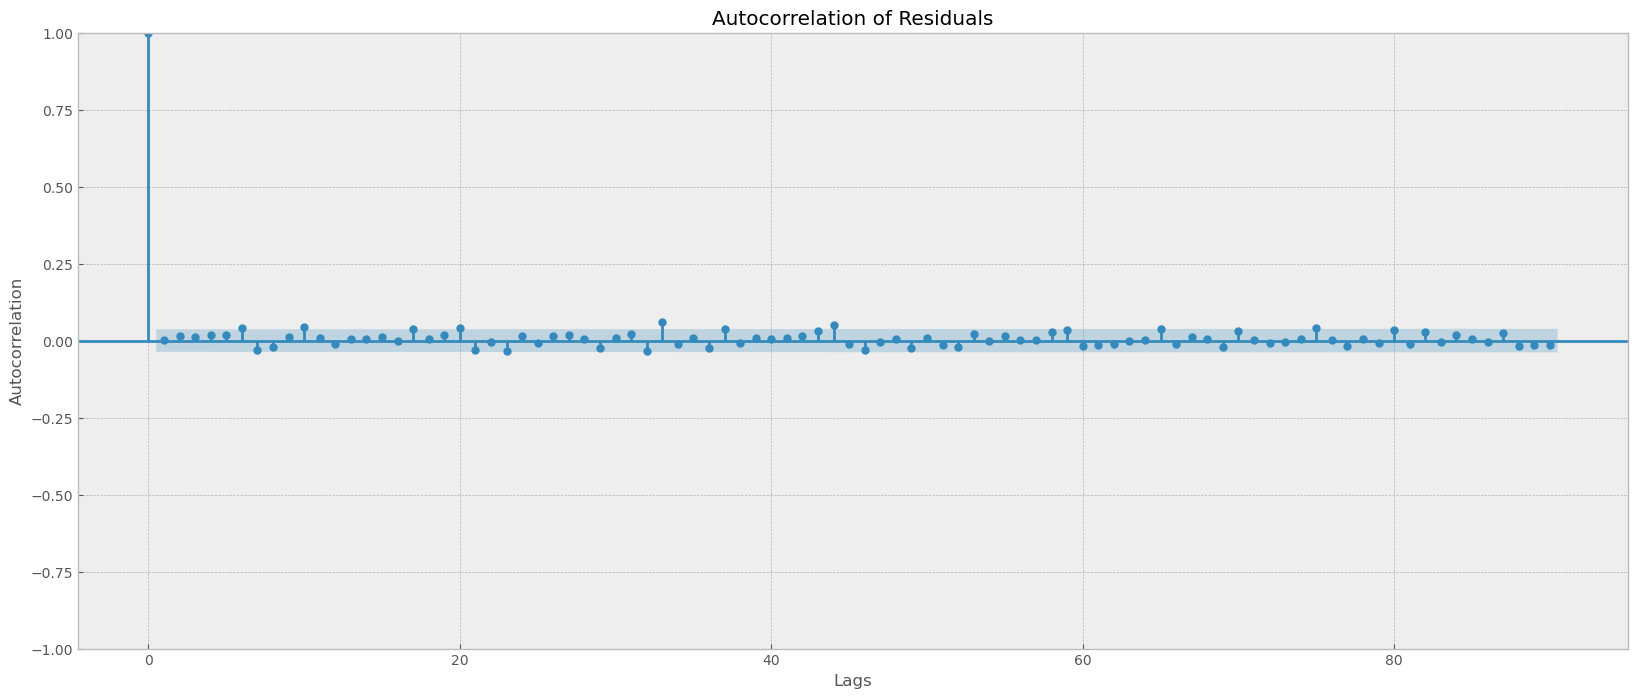

In [126]:
plt.figure(figsize=(10, 6))
plot_acf(train_df['arimax_residuals'].dropna(), lags=90, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Prediction of the test data

Test RMSE: 4195.072


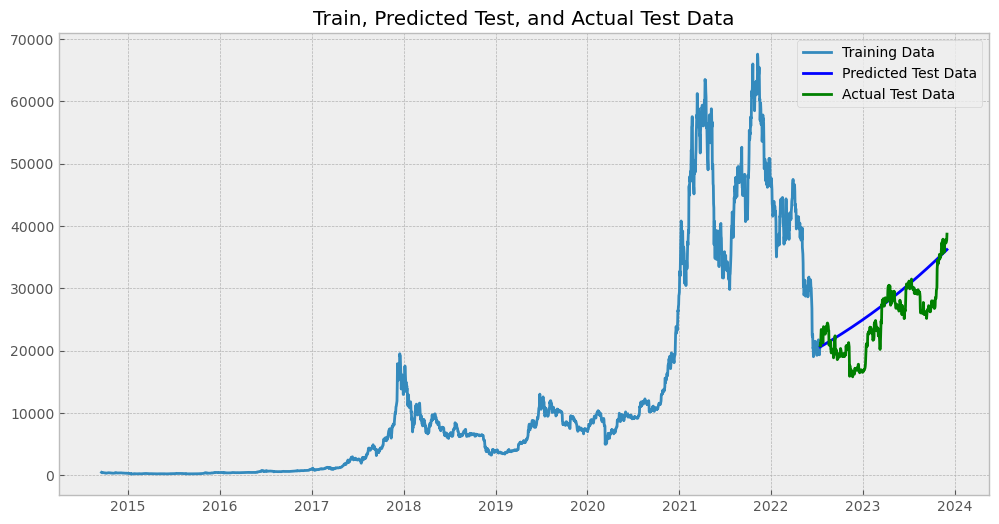

In [127]:
test_df['epoch'] = (test_df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
predictions = forecast_and_plot(model_fit, train_df, test_df, transformed=True, lambda_optimal=lambda_optimal, exg=test_df['epoch'])

In [128]:
test_df['arimax_prediction'] = predictions
arimax_metrics = calculate_forecast_metrics(test_df.dropna(), actual_col='Close', benchmark_cols=['arimax_prediction'])
arimax_metrics.T

MAE           MSE         RMSE       MAPE        R2
arimax_prediction  3364.390961  1.759863e+07  4195.072128  15.502013  0.390497

The model is not capturing the voitality in the test data but the trend is correctly predcited

## Gradient boosting<a name="boosting"></a>


Gradient boosting is fairly robust to the distribution of features it can handble high variancs, non gaussian distribution and outlirs without transforming th data therfor no BoxCox transformation is applied to the data training data.

The following features that could be extracted from the date are used as input features for the gradient boosting:
- year
- month
- day
- weekday 

In [129]:
# Convert date column to datetime and extract date features
def split_date(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    
    return df

In [130]:
train_df = split_date(train_df)
test_df = split_date(test_df)

#features and target for the gradient boosting
features = ['year','month','day', 'weekday']
target_variable = 'Close'

Create the gradient boosting model hyperparameters are tuned with cross validation for time series

In [131]:
#create gradient boosting model and prdictions for train and test data
model, trainPredictions, testPredictions, trainR2, testR2 = gradient_boosting(train_df,test_df,features,target_variable)
test_df['gboosting_prediction'] = testPredictions
train_df['gboosting_model'] = trainPredictions

709


Performace on the train data

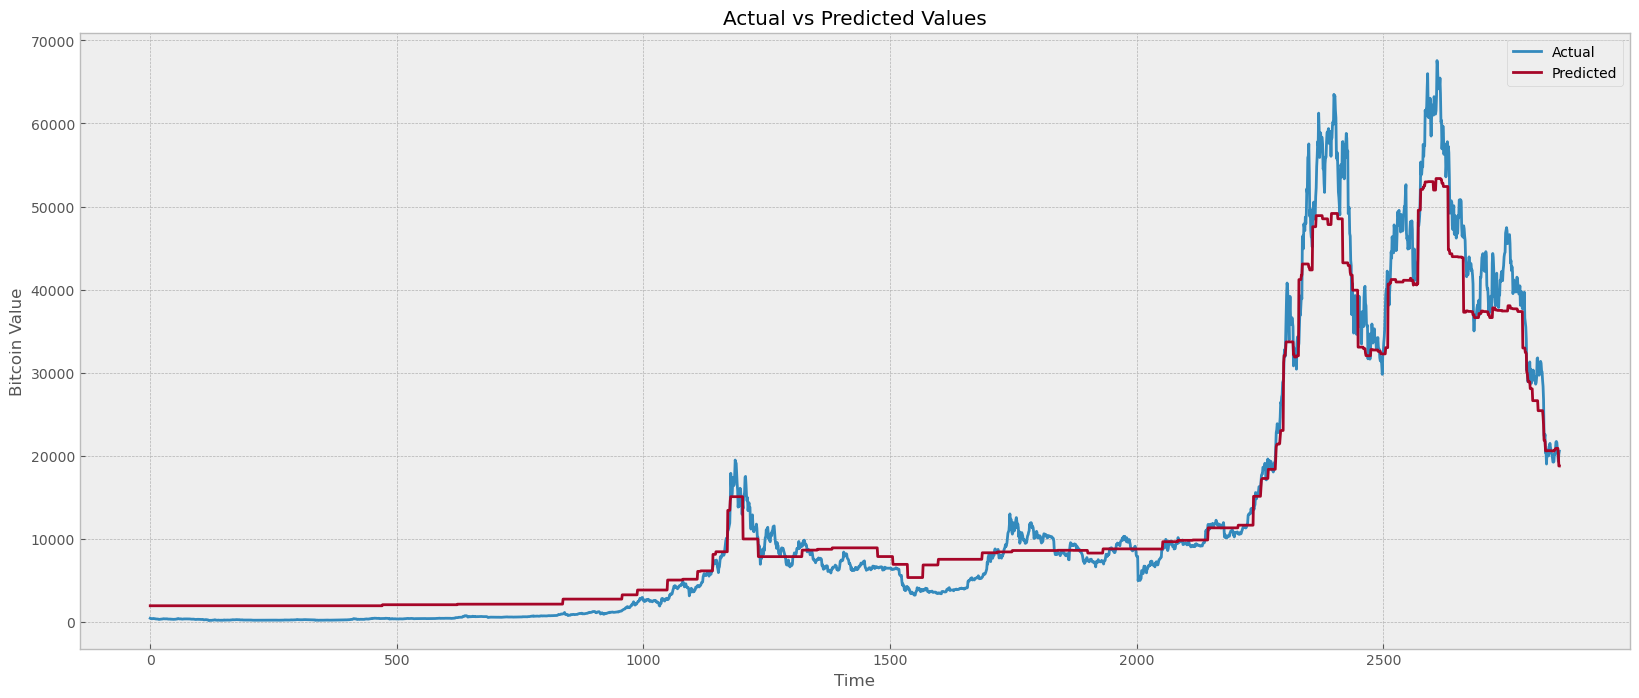

In [132]:
create_plot(train_df[target_variable], trainPredictions)

In [133]:
print(f"R2 score of gradient boosting model: {trainR2}")

R2 score of gradient boosting model: 0.966707961084771


In [134]:
train_df.head()

date        Open        High         Low       Close   
date                                                                    
2014-09-17 2014-09-17  465.864014  468.174011  452.421997  457.334015  \
2014-09-18 2014-09-18  456.859985  456.859985  413.104004  424.440002   
2014-09-19 2014-09-19  424.102997  427.834991  384.532013  394.795990   
2014-09-20 2014-09-20  394.673004  423.295990  389.882996  408.903992   
2014-09-21 2014-09-21  408.084991  412.425995  393.181000  398.821014   

             Adj Close    Volume currency Dataset        mov1  ...   
date                                                           ...   
2014-09-17  457.334015  21056800  BTC-USD   Train  457.334015  ...  \
2014-09-18  424.440002  34483200  BTC-USD   Train  424.440002  ...   
2014-09-19  394.795990  37919700  BTC-USD   Train  394.795990  ...   
2014-09-20  408.903992  36863600  BTC-USD   Train  408.903992  ...   
2014-09-21  398.821014  26580100  BTC-USD   Train  398.821014  ...   

            arima3_1_3_prediction  arima1_1_2_residuals       epoch   
date                                                                  
2014-09-17                    NaN                   NaN  1410912000  \
2014-09-18                    NaN                   NaN  1410998400   
2014-09-19                    NaN            -30.269406  1411084800   
2014-09-20             394.384797             13.902543  1411171200   
2014-09-21             408.067183             -9.065572  1411257600   

            ARIMAX_prediction  arimax_residuals  year  month  day  weekday   
date                                                                         
2014-09-17                NaN               NaN  2014      9   17        2  \
2014-09-18           7.933431         -0.124787  2014      9   18        3   
2014-09-19           7.813835         -0.123041  2014      9   19        4   
2014-09-20           7.695893          0.051966  2014      9   20        5   
2014-09-21           7.749274         -0.042010  2014      9   21        6   

            gboosting_model  
date                         
2014-09-17      1962.654541  
2014-09-18      1962.654541  
2014-09-19      1962.654541  
2014-09-20      1962.654541  
2014-09-21      1962.654541  

[5 rows x 60 columns]

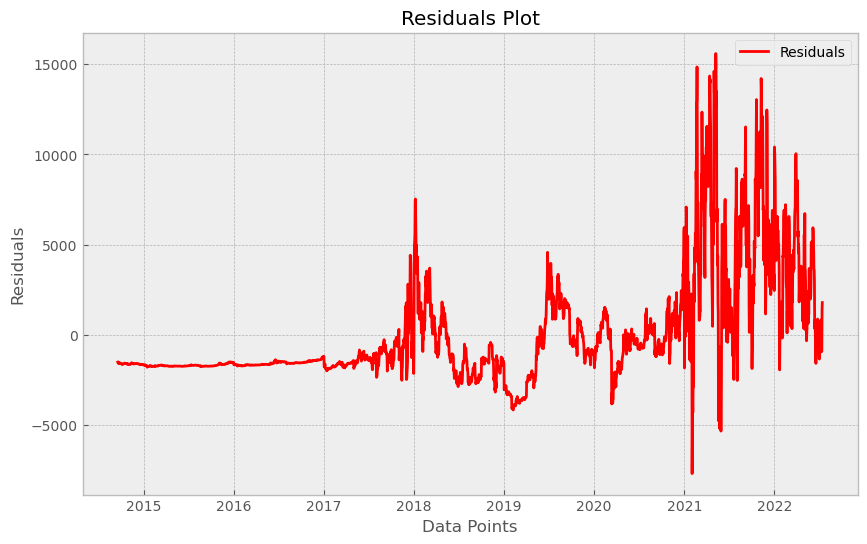

In [135]:
#Check residuals
# Plot residuals
#train_df['arimax_residuals'] = train_df['Close'] - inv_boxcox(train_df['ARIMAX_prediction'],lambda_optimal)
train_df['gboosting_residuals'] = train_df['Close'] - train_df['gboosting_model']


plt.figure(figsize=(10, 6))
plt.plot(train_df['gboosting_residuals'], label='Residuals', color='red')
plt.title('Residuals Plot')
plt.xlabel('Data Points')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [136]:
mean_residuals = train_df['gboosting_residuals'].mean()
variance_residuals = train_df['gboosting_residuals'].var()

print(f"Mean of residuals: {mean_residuals}")
print(f"Variance of residuals: {variance_residuals}")

Mean of residuals: 25.451515277838524
Variance of residuals: 9133182.95618811


In [137]:
sm.stats.acorr_ljungbox(train_df['gboosting_residuals'].dropna(), lags=[1,30,90,365,730], return_df=True)

lb_stat  lb_pvalue
1      2626.607053        0.0
30    44971.998607        0.0
90    99677.284567        0.0
365  192334.096791        0.0
730  204306.544197        0.0

<Figure size 1000x600 with 0 Axes>

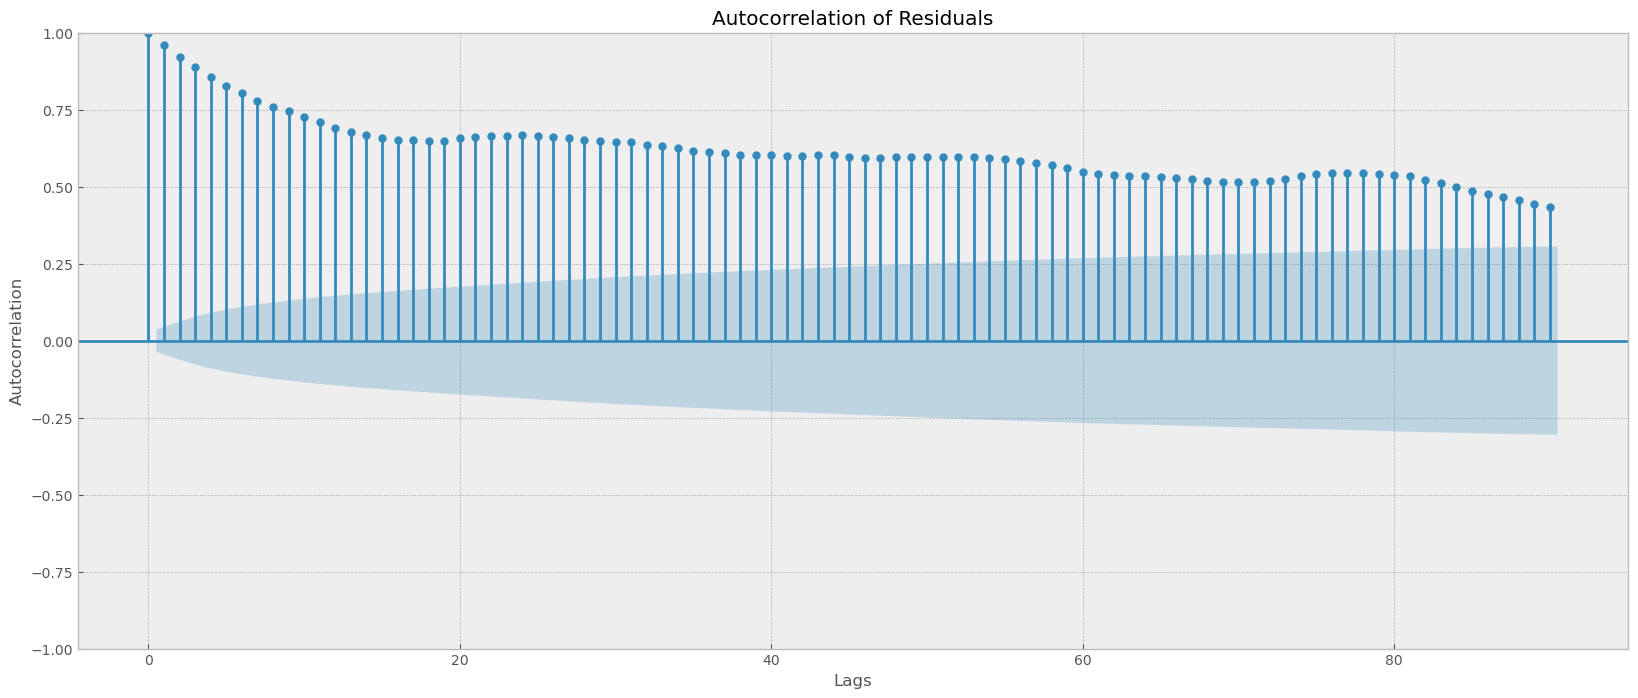

In [138]:
plt.figure(figsize=(10, 6))
plot_acf(train_df['gboosting_residuals'].dropna(), lags=90, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Residuals are not a white noise process the modl fails to capture some of the structures of the time series

### Performance on the test data 

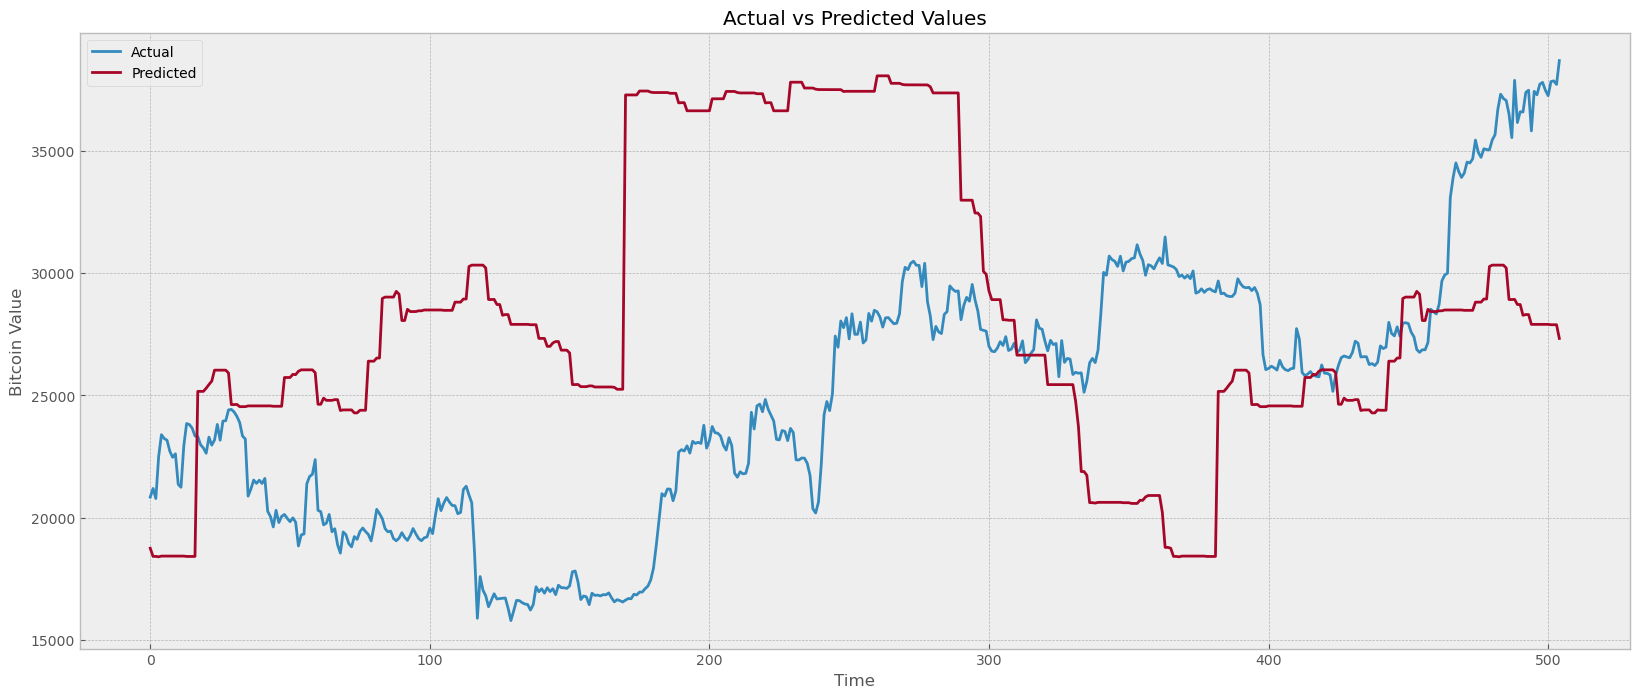

In [139]:
create_plot(test_df['Close'], testPredictions)

In [140]:
# calculate predictin metrics
gb_metrics = calculate_forecast_metrics(test_df.dropna(), actual_col='Close', benchmark_cols=['gboosting_prediction'])
gb_metrics.T

MAE           MSE         RMSE       MAPE   
gboosting_prediction  7422.246569  7.865986e+07  8869.039299  32.770634  \

                            R2  
gboosting_prediction -1.724269

Predictions are quit far of and the model also fails to capture the general trend in the test data. The gradient boosting model shows more volatility then the ARIMA(X) models put the prdicted jumps are not accurate. 

## Merton jump diffusion model<a name="diffusion"></a>

Bitcoin value can be considerd a diffusion process as bitcoin and crypto currency in general is still a new market. As the timeseries has a lot of volatility the standard diffusion models did not perform well therefore try a jump diffusion model.

Based on the training data model 10.000 posiible pathes for the time of the test data set 

5 largest positive single day moves  [0.5916, 0.2681, 0.2306, 0.2222, 0.2027]
5 largest negative single day moves [-0.2016, -0.1931, -0.1662, -0.1579, -0.1539]
The probability of jump is 0.059 %


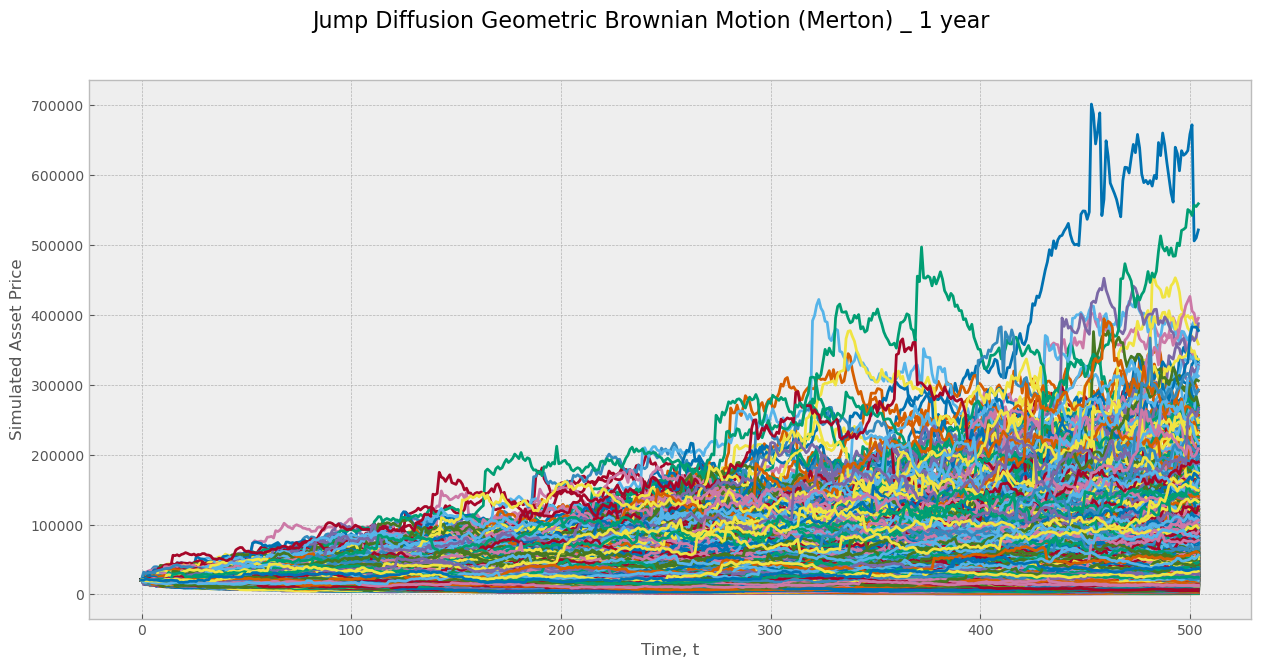

In [141]:
#create mertons jump diffusion model and simulate possible future pathes 
mp, jump_diffusion_examples = merton_jump_diffusion(train_df,'Close',len(test_df))

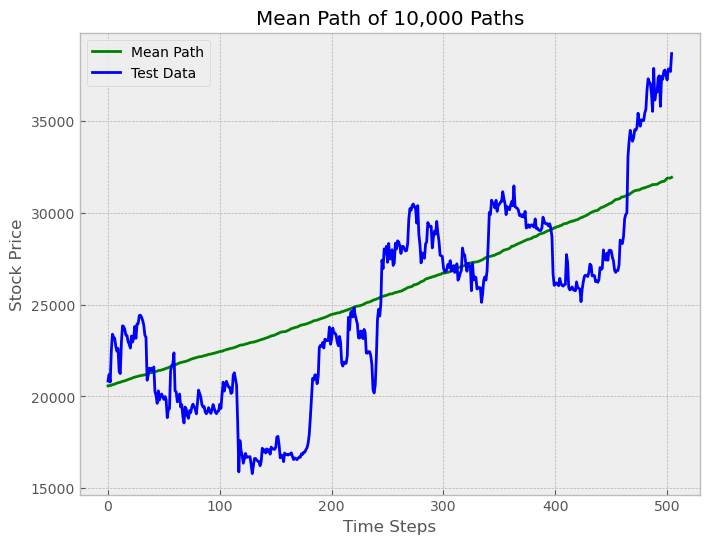

R-squared score: 0.5948063957492282


In [142]:
#avg path of all the simulated pathes compared to the test data 
mean_path = plot_avg_train(jump_diffusion_examples, test_df, 'Close',len(test_df))

In [143]:
test_df['jd_prediction'] = mean_path

In [144]:
#calculate metrics for predictions with the mean_path
diffusion_metrics = calculate_forecast_metrics(test_df, actual_col='Close', benchmark_cols=['jd_prediction'])
diffusion_metrics.T

MAE           MSE         RMSE       MAPE        R2
jd_prediction  2840.926887  1.169946e+07  3420.446968  12.699206  0.594806

# Result<a name="result"></a>

In [145]:
#combine all the mtrics
#all_metrics_df = pd.concat([diffusion_metrics.T,gb_metrics.T,gam_metrics.T,arima_metrics.T,benchmark_metrics.T, arimax_metrics.T],axis=0)

all_metrics_df = pd.concat([diffusion_metrics.T,gb_metrics.T,arima_metrics.T,benchmark_metrics.T, arimax_metrics.T],axis=0)

In [146]:
sorted_df = all_metrics_df.sort_values(by='MSE')
sorted_df.head(20)

MAE           MSE         RMSE       MAPE   
jd_prediction          2840.926887  1.169946e+07  3420.446968  12.699206  \
arimax_prediction      3364.390961  1.759863e+07  4195.072128  15.502013   
bench_drift_Close      4259.440336  2.769475e+07  5262.579713  16.324904   
arima3_1_0_prediction  5551.118261  4.761991e+07  6900.717792  20.416673   
arima3_1_1_prediction  5551.135243  4.762020e+07  6900.739054  20.416722   
arima1_1_3_prediction  5552.006300  4.763591e+07  6901.877103  20.419154   
arima0_1_3_prediction  5552.128618  4.763819e+07  6902.042687  20.419486   
arima0_1_2_prediction  5555.576444  4.770107e+07  6906.596149  20.429039   
arima2_1_0_prediction  5555.834507  4.770574e+07  6906.934289  20.429758   
arima2_1_1_prediction  5558.658884  4.775253e+07  6910.320290  20.438141   
arima0_1_0_prediction  5562.778895  4.783143e+07  6916.026724  20.449146   
bench_naive_Close      5562.778895  4.783143e+07  6916.026724  20.449146   
arima1_1_1_prediction  5564.490768  4.786240e+07  6918.265572  20.453934   
arima1_1_0_prediction  5566.181707  4.789305e+07  6920.480595  20.458659   
arima0_1_1_prediction  5566.296820  4.789514e+07  6920.631702  20.458980   
arima2_0_3_prediction  5706.566770  5.046171e+07  7103.640864  20.916991   
arima3_0_2_prediction  5734.649603  5.098640e+07  7140.476468  21.007942   
arima3_0_3_prediction  5806.214910  5.232786e+07  7233.799987  21.235478   
arima1_1_2_prediction  6247.337040  6.099576e+07  7809.978170  22.484260   
arima3_1_3_prediction  6686.893308  6.950918e+07  8337.216857  23.950680   

                             R2  
jd_prediction          0.594806  
arimax_prediction      0.390497  
bench_drift_Close      0.040833  
arima3_1_0_prediction -0.649246  
arima3_1_1_prediction -0.649256  
arima1_1_3_prediction -0.649800  
arima0_1_3_prediction -0.649879  
arima0_1_2_prediction -0.652057  
arima2_1_0_prediction -0.652219  
arima2_1_1_prediction -0.653839  
arima0_1_0_prediction -0.656571  
bench_naive_Close     -0.656571  
arima1_1_1_prediction -0.657644  
arima1_1_0_prediction -0.658706  
arima0_1_1_prediction -0.658778  
arima2_0_3_prediction -0.747668  
arima3_0_2_prediction -0.765840  
arima3_0_3_prediction -0.812299  
arima1_1_2_prediction -1.112499  
arima3_1_3_prediction -1.407349

Only the jump diffusion model, ARIMAX model (and GAM model) perform better than the benchmaring models. The best predictions are achived with the mean path of the jump diffusion model as this method as th lowest MAE,MSE, RMSE and MAPE score and the highest R2 score 

# Investment strategy<a name="investment"></a>

In [147]:
train_df['ARIMAX_pred_transform'] = inverse_bocxcx(train_df['ARIMAX_prediction'], lambda_optimal)

In [148]:
# Calculate daily returns
train_df['daily_returns'] = np.log(train_df['Close'] / train_df['Close'].shift(1))

# Generate positions based on the predictions
train_df['position'] = np.sign(train_df['ARIMAX_pred_transform'] - train_df['Close'].shift(1))

# Calculate strategy returns
train_df['strategy_arimax_returns'] = train_df['position'].shift(1) * train_df['daily_returns']

train_df.head()

date        Open        High         Low       Close   
date                                                                    
2014-09-17 2014-09-17  465.864014  468.174011  452.421997  457.334015  \
2014-09-18 2014-09-18  456.859985  456.859985  413.104004  424.440002   
2014-09-19 2014-09-19  424.102997  427.834991  384.532013  394.795990   
2014-09-20 2014-09-20  394.673004  423.295990  389.882996  408.903992   
2014-09-21 2014-09-21  408.084991  412.425995  393.181000  398.821014   

             Adj Close    Volume currency Dataset        mov1  ...  month   
date                                                           ...          
2014-09-17  457.334015  21056800  BTC-USD   Train  457.334015  ...      9  \
2014-09-18  424.440002  34483200  BTC-USD   Train  424.440002  ...      9   
2014-09-19  394.795990  37919700  BTC-USD   Train  394.795990  ...      9   
2014-09-20  408.903992  36863600  BTC-USD   Train  408.903992  ...      9   
2014-09-21  398.821014  26580100  BTC-USD   Train  398.821014  ...      9   

            day  weekday  gboosting_model  gboosting_residuals  differance   
date                                                                         
2014-09-17   17        2      1962.654541         -1505.320526    0.074643  \
2014-09-18   18        3      1962.654541         -1538.214539    0.072402   
2014-09-19   19        4      1962.654541         -1567.858551   -0.035111   
2014-09-20   20        5      1962.654541         -1553.750549    0.024968   
2014-09-21   21        6      1962.654541         -1563.833527   -0.008317   

            ARIMAX_pred_transform  daily_returns  position   
date                                                         
2014-09-17                    NaN            NaN       NaN  \
2014-09-18             458.048164      -0.074643       1.0   
2014-09-19             425.791740      -0.072402       1.0   
2014-09-20             396.038241       0.035111       1.0   
2014-09-21             409.259566      -0.024968       1.0   

            strategy_arimax_returns  
date                                 
2014-09-17                      NaN  
2014-09-18                      NaN  
2014-09-19                -0.072402  
2014-09-20                 0.035111  
2014-09-21                -0.024968  

[5 rows x 66 columns]

In [149]:
# Calculate daily returns
test_df['daily_returns'] = np.log(test_df['Close'] / test_df['Close'].shift(1))

# Generate positions based on the predictions
test_df['position'] = np.sign(test_df['arimax_prediction'] - test_df['Close'].shift(1))

# Calculate strategy returns
test_df['strategy_arimax_returns'] = test_df['position'].shift(1) * test_df['daily_returns']

test_df.head()

date          Open          High           Low         Close   
date                                                                            
2022-07-15 2022-07-15  20573.156250  21138.244141  20397.000000  20836.328125  \
2022-07-16 2022-07-16  20834.103516  21514.404297  20518.898438  21190.316406   
2022-07-17 2022-07-17  21195.041016  21600.640625  20778.179688  20779.343750   
2022-07-18 2022-07-18  20781.912109  22633.033203  20781.912109  22485.689453   
2022-07-19 2022-07-19  22467.849609  23666.962891  21683.406250  23389.433594   

               Adj Close       Volume currency Dataset  bench_mean_Close  ...   
date                                                                      ...   
2022-07-15  20836.328125  25905575359  BTC-USD    Test      12460.989965  ...  \
2022-07-16  21190.316406  24302954056  BTC-USD    Test      12460.989965  ...   
2022-07-17  20779.343750  22927802083  BTC-USD    Test      12460.989965  ...   
2022-07-18  22485.689453  39974475562  BTC-USD    Test      12460.989965  ...   
2022-07-19  23389.433594  48765202697  BTC-USD    Test      12460.989965  ...   

            arimax_prediction  year  month  day  weekday   
date                                                       
2022-07-15       20586.405819  2022      7   15        4  \
2022-07-16       20610.167613  2022      7   16        5   
2022-07-17       20633.801410  2022      7   17        6   
2022-07-18       20657.463342  2022      7   18        0   
2022-07-19       20681.150139  2022      7   19        1   

            gboosting_prediction  jd_prediction  daily_returns  position   
date                                                                       
2022-07-15          18745.691406   20569.919922            NaN       NaN  \
2022-07-16          18412.509766   20589.124339       0.016846      -1.0   
2022-07-17          18412.509766   20582.634528      -0.019585      -1.0   
2022-07-18          18394.464844   20612.070726       0.078920      -1.0   
2022-07-19          18424.955078   20634.767546       0.039405      -1.0   

            strategy_arimax_returns  
date                                 
2022-07-15                      NaN  
2022-07-16                      NaN  
2022-07-17                 0.019585  
2022-07-18                -0.078920  
2022-07-19                -0.039405  

[5 rows x 56 columns]

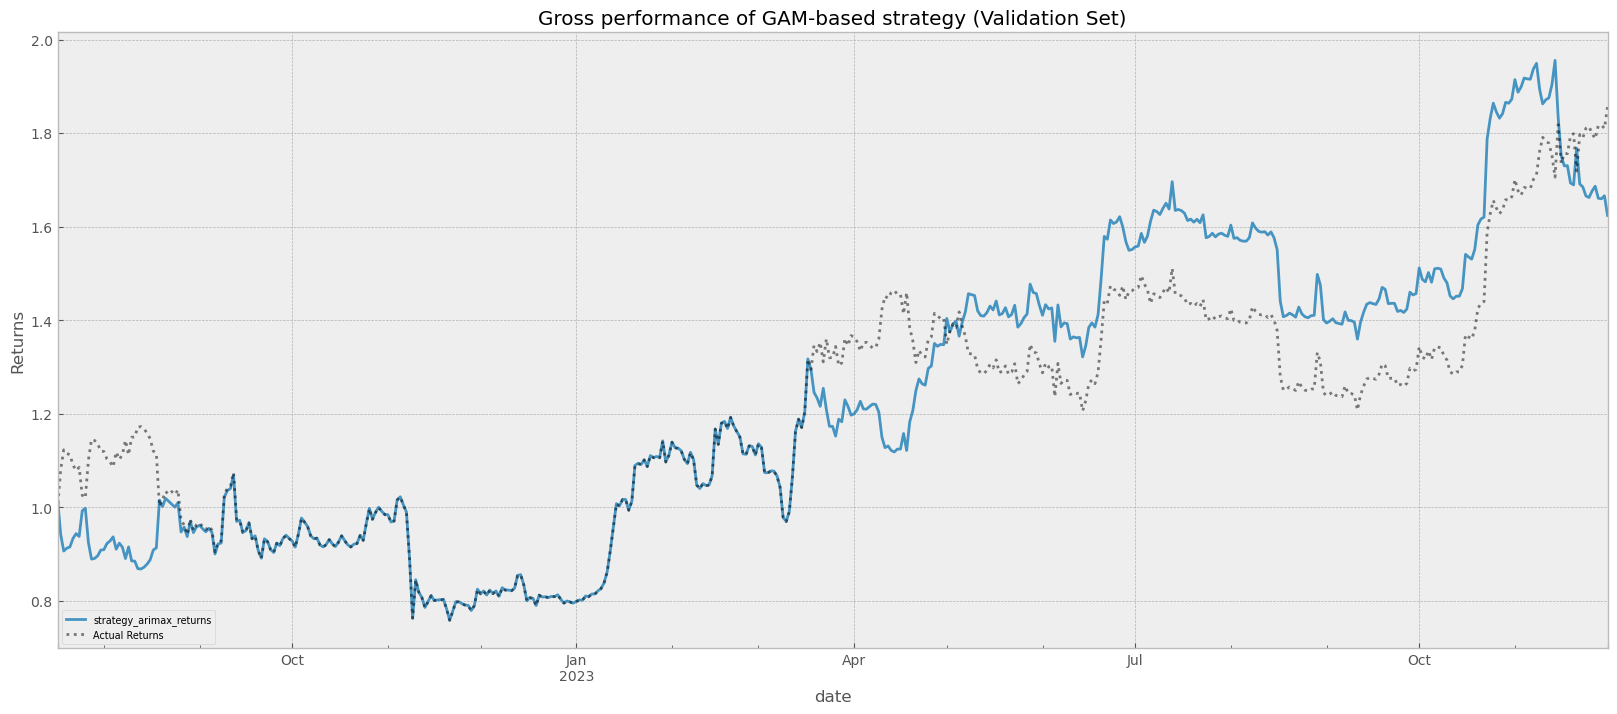

In [150]:
test_df['strategy_arimax_returns'].dropna().cumsum().apply(np.exp).plot(alpha=0.9)
plt.plot(test_df['daily_returns'].dropna().cumsum().apply(np.exp), color='black', label='Actual Returns', alpha=0.5, linestyle='dotted')
plt.ylabel("Returns")
plt.title("Gross performance of GAM-based strategy (Validation Set)")
plt.legend(loc='lower left', fontsize='x-small')
plt.show()

In [151]:
# Calculate daily returns
test_df['daily_returns'] = np.log(test_df['Close'] / test_df['Close'].shift(1))

# Generate positions based on the predictions
test_df['position_jd'] = np.sign(test_df['jd_prediction'] - test_df['Close'].shift(1))

# Calculate strategy returns
test_df['strategy_jd_returns'] = test_df['position_jd'].shift(1) * test_df['daily_returns']

test_df.head()

date          Open          High           Low         Close   
date                                                                            
2022-07-15 2022-07-15  20573.156250  21138.244141  20397.000000  20836.328125  \
2022-07-16 2022-07-16  20834.103516  21514.404297  20518.898438  21190.316406   
2022-07-17 2022-07-17  21195.041016  21600.640625  20778.179688  20779.343750   
2022-07-18 2022-07-18  20781.912109  22633.033203  20781.912109  22485.689453   
2022-07-19 2022-07-19  22467.849609  23666.962891  21683.406250  23389.433594   

               Adj Close       Volume currency Dataset  bench_mean_Close  ...   
date                                                                      ...   
2022-07-15  20836.328125  25905575359  BTC-USD    Test      12460.989965  ...  \
2022-07-16  21190.316406  24302954056  BTC-USD    Test      12460.989965  ...   
2022-07-17  20779.343750  22927802083  BTC-USD    Test      12460.989965  ...   
2022-07-18  22485.689453  39974475562  BTC-USD    Test      12460.989965  ...   
2022-07-19  23389.433594  48765202697  BTC-USD    Test      12460.989965  ...   

            month  day  weekday  gboosting_prediction  jd_prediction   
date                                                                   
2022-07-15      7   15        4          18745.691406   20569.919922  \
2022-07-16      7   16        5          18412.509766   20589.124339   
2022-07-17      7   17        6          18412.509766   20582.634528   
2022-07-18      7   18        0          18394.464844   20612.070726   
2022-07-19      7   19        1          18424.955078   20634.767546   

            daily_returns  position  strategy_arimax_returns  position_jd   
date                                                                        
2022-07-15            NaN       NaN                      NaN          NaN  \
2022-07-16       0.016846      -1.0                      NaN         -1.0   
2022-07-17      -0.019585      -1.0                 0.019585         -1.0   
2022-07-18       0.078920      -1.0                -0.078920         -1.0   
2022-07-19       0.039405      -1.0                -0.039405         -1.0   

            strategy_jd_returns  
date                             
2022-07-15                  NaN  
2022-07-16                  NaN  
2022-07-17             0.019585  
2022-07-18            -0.078920  
2022-07-19            -0.039405  

[5 rows x 58 columns]

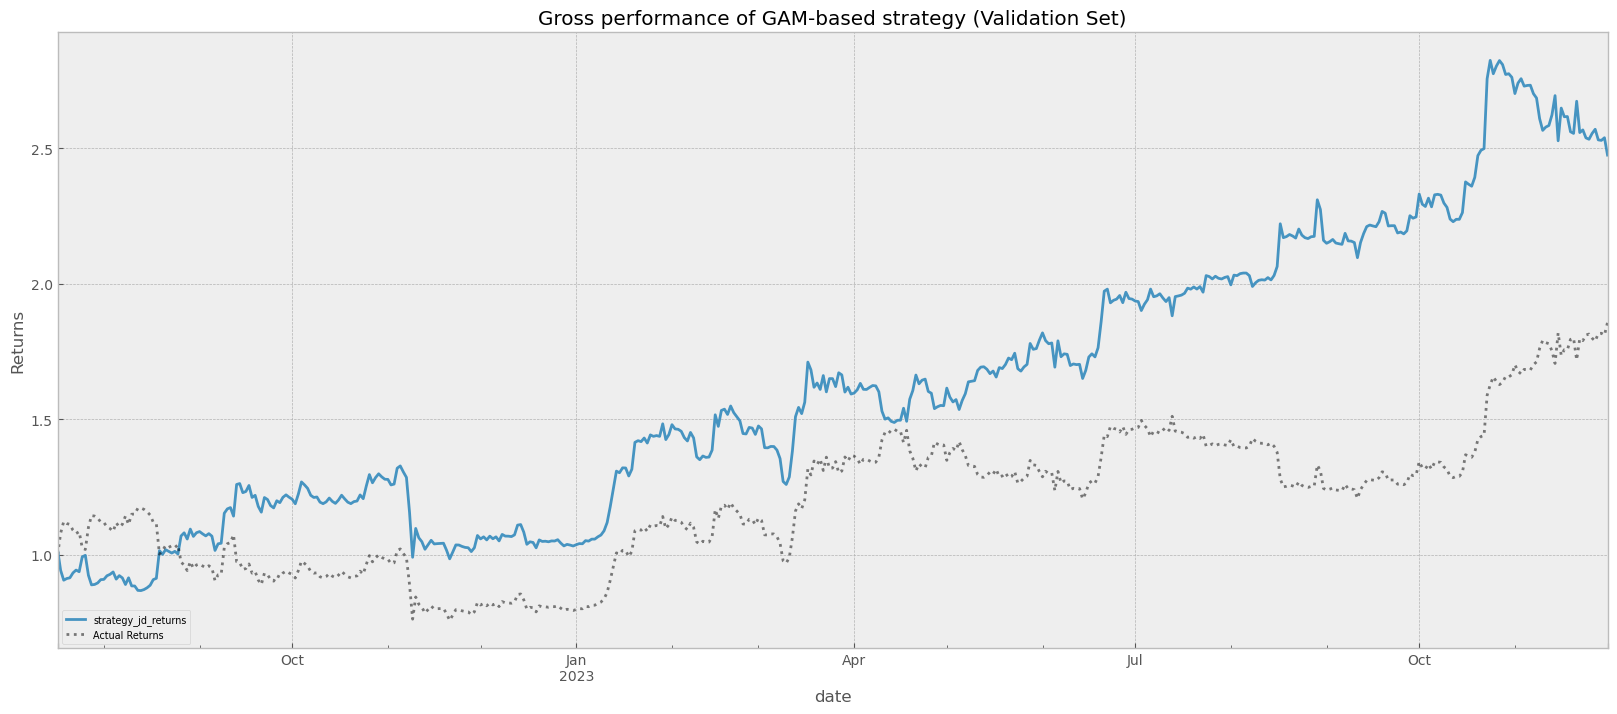

In [152]:
test_df['strategy_jd_returns'].dropna().cumsum().apply(np.exp).plot(alpha=0.9)
plt.plot(test_df['daily_returns'].dropna().cumsum().apply(np.exp), color='black', label='Actual Returns', alpha=0.5, linestyle='dotted')
plt.ylabel("Returns")
plt.title("Gross performance of GAM-based strategy (Validation Set)")
plt.legend(loc='lower left', fontsize='x-small')
plt.show()

Based on the returns the ARIMAX model is better for a short term investment strategy

# Long term investments 
XX year investment
jump_diffusion_examples

In [58]:
S0 = train_df.iloc[-1]['Close']

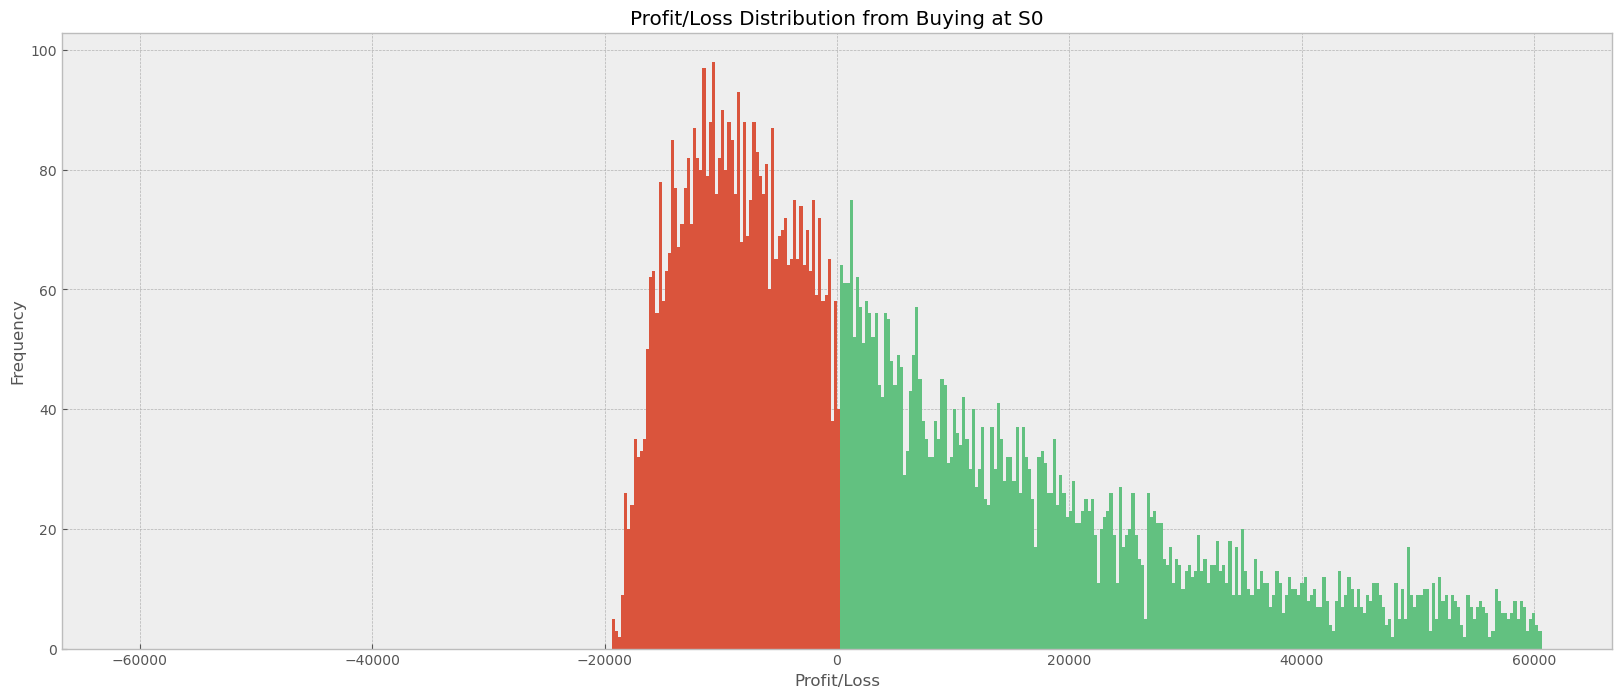

Mean: 11912.301044386422
Minimum: -19353.165059293715
Maximum: 556371.251808439
25th percentile (Q1): -8452.454595716814
Median (50th percentile): 1396.5683468551833
75th percentile (Q3): 19038.500103445745


In [59]:
get_profit_loss(S0, jump_diffusion_examples)

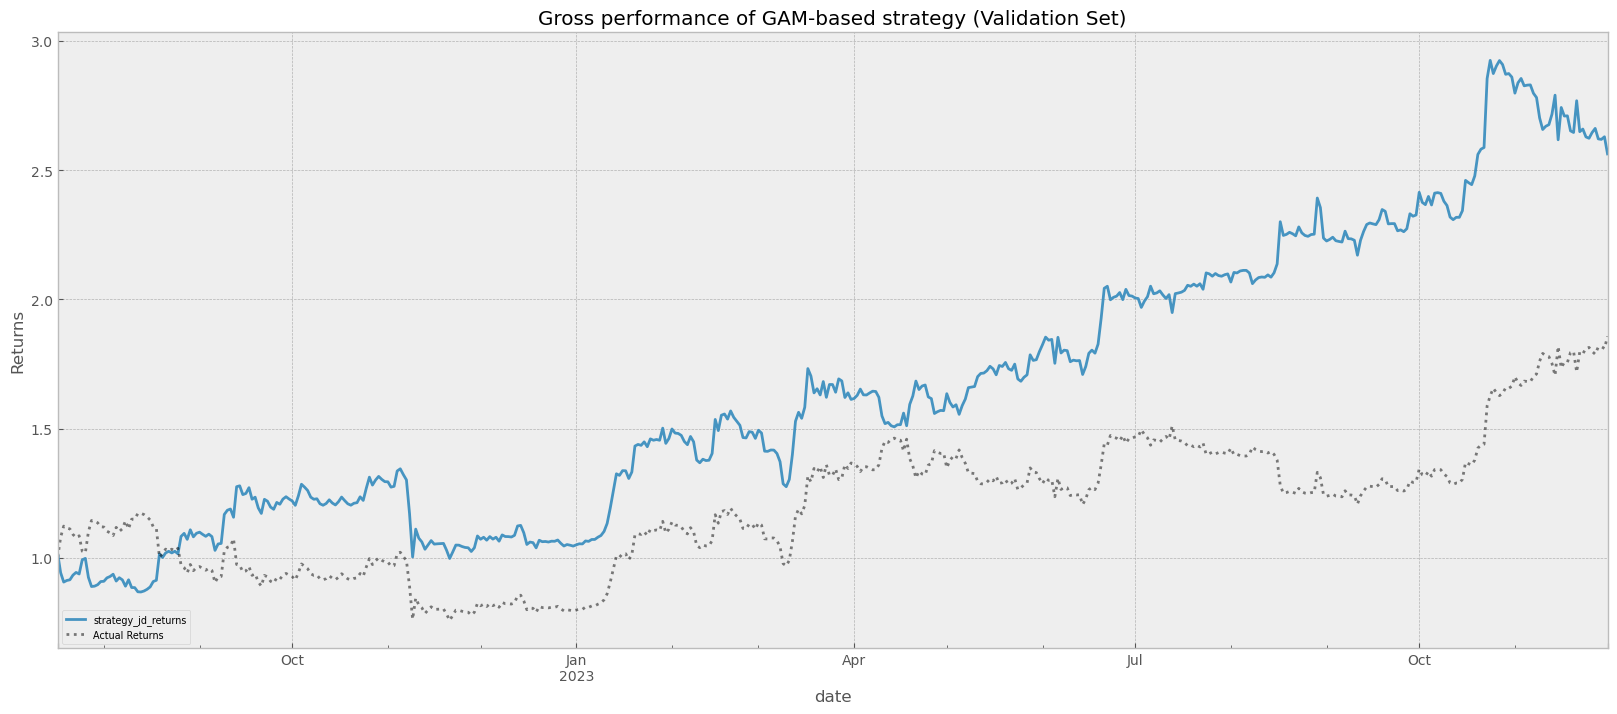

In [85]:
test_df['strategy_jd_returns'].dropna().cumsum().apply(np.exp).plot(alpha=0.9)
plt.plot(test_df['daily_returns'].dropna().cumsum().apply(np.exp), color='black', label='Actual Returns', alpha=0.5, linestyle='dotted')
plt.ylabel("Returns")
plt.title("Gross performance of GAM-based strategy (Validation Set)")
plt.legend(loc='lower left', fontsize='x-small')
plt.show()

In [84]:
# Calculate daily returns
test_df['daily_returns'] = np.log(test_df['Close'] / test_df['Close'].shift(1))

# Generate positions based on the predictions
test_df['position_jd'] = np.sign(test_df['jd_prediction'] - test_df['Close'].shift(1))

# Calculate strategy returns
test_df['strategy_jd_returns'] = test_df['position_jd'].shift(1) * test_df['daily_returns']

test_df.head()

date          Open          High           Low         Close   
date                                                                            
2022-07-15 2022-07-15  20573.156250  21138.244141  20397.000000  20836.328125  \
2022-07-16 2022-07-16  20834.103516  21514.404297  20518.898438  21190.316406   
2022-07-17 2022-07-17  21195.041016  21600.640625  20778.179688  20779.343750   
2022-07-18 2022-07-18  20781.912109  22633.033203  20781.912109  22485.689453   
2022-07-19 2022-07-19  22467.849609  23666.962891  21683.406250  23389.433594   

               Adj Close       Volume currency Dataset  bench_mean_Close  ...   
date                                                                      ...   
2022-07-15  20836.328125  25905575359  BTC-USD    Test      12460.989965  ...  \
2022-07-16  21190.316406  24302954056  BTC-USD    Test      12460.989965  ...   
2022-07-17  20779.343750  22927802083  BTC-USD    Test      12460.989965  ...   
2022-07-18  22485.689453  39974475562  BTC-USD    Test      12460.989965  ...   
2022-07-19  23389.433594  48765202697  BTC-USD    Test      12460.989965  ...   

            month  day  weekday  gboosting_prediction  jd_prediction   
date                                                                   
2022-07-15      7   15        4          18745.691406   20569.919922  \
2022-07-16      7   16        5          18412.509766   20587.397475   
2022-07-17      7   17        6          18412.509766   20621.468566   
2022-07-18      7   18        0          18394.464844   20647.984420   
2022-07-19      7   19        1          18424.955078   20673.820654   

            daily_returns  position  strategy_arimax_returns  position_jd   
date                                                                        
2022-07-15            NaN       NaN                      NaN          NaN  \
2022-07-16       0.016846      -1.0                      NaN         -1.0   
2022-07-17      -0.019585      -1.0                 0.019585         -1.0   
2022-07-18       0.078920      -1.0                -0.078920         -1.0   
2022-07-19       0.039405      -1.0                -0.039405         -1.0   

            strategy_jd_returns  
date                             
2022-07-15                  NaN  
2022-07-16                  NaN  
2022-07-17             0.019585  
2022-07-18            -0.078920  
2022-07-19            -0.039405  

[5 rows x 58 columns]